## Boilerplate

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib
import scipy.stats
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
# Pretty Plots
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})
def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [3]:
import gym
import torch
import pybullet_envs
from stable_baselines3 import PPO, SAC
from torch import nn
from stable_baselines3.common.vec_env import VecNormalize
from gym.spaces import Box

In [4]:
from typing import Callable, Union, Type, Optional, Dict, Any

import gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecEnv
import os

# From https://github.com/DLR-RM/rl-baselines3-zoo/blob/8ea4f4a87afa548832ca17e575b351ec5928c1b0/utils/utils.py
def linear_schedule(initial_value: Union[float, str]) -> Callable[[float], float]:
    """
    Linear learning rate schedule.
    :param initial_value: (float or str)
    :return: (function)
    """
    if isinstance(initial_value, str):
        initial_value = float(initial_value)

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0
        :param progress_remaining: (float)
        :return: (float)
        """
        return progress_remaining * initial_value

    return func

## Environments

In [5]:
class HCWrapper(gym.Wrapper):
    def __init__(self, env, target_vis=False):
        super().__init__(env)
        self.target = np.random.uniform(0.0, 3.0)
        self.env = env
        self.env.reset()
        self.target_vis = target_vis
        self.dt = self.env.env.robot.scene.dt
        if self.target_vis:
            self.observation_space = Box(low=-np.inf * np.ones(env.observation_space.shape[0] + 2),
                                         high=np.inf * np.ones(env.observation_space.shape[0] + 2))
        else:
            self.observation_space = Box(low=-np.inf * np.ones(env.observation_space.shape[0] + 1),
                                         high=np.inf * np.ones(env.observation_space.shape[0] + 1))   

    def reset(self):
        self.target = np.random.uniform(0.0, 3.0)
        obs = self.env.reset()
        if self.target_vis:
            obs = np.concatenate([obs, [-1], [self.target]])
        else:
            obs = np.concatenate([obs, [-1]])
        return obs

    def step(self, action):
        p = self.env.robot.robot_body.get_pose()[0]
        next_obs, _, done, info = self.env.step(action)
        p_prime = self.env.robot.robot_body.get_pose()[0]
        vel = (p_prime - p) / (self.dt)
        ind = 1 if vel > self.target else -1.0
        print(vel, self.target)
        if self.target_vis:
            next_obs = np.concatenate([next_obs, [ind], [self.target]])
        else:
            next_obs = np.concatenate([next_obs, [ind]])
        forward_reward = -1.0 * abs(vel - self.target)
        ctrl_cost = 0.5 * 1e-1 * np.sum(np.square(action))
        reward = forward_reward - ctrl_cost
        return next_obs, reward, done, info

In [327]:
class AntWrapper(gym.Wrapper):
    def __init__(self, env, target_vis=False):
        super().__init__(env)
        self.target = np.random.uniform(0.0, 1.5)
        self.env = env
        self.env.reset()
        self.target_vis = target_vis
        self.dt = self.env.env.robot.scene.dt
        if self.target_vis:
            self.observation_space = Box(low=-np.inf * np.ones(env.observation_space.shape[0] + 2),
                                         high=np.inf * np.ones(env.observation_space.shape[0] + 2))
        else:
            self.observation_space = Box(low=-np.inf * np.ones(env.observation_space.shape[0] + 1),
                                         high=np.inf * np.ones(env.observation_space.shape[0] + 1))   
        self.t = 0

    def reset(self):
        self.target = np.random.uniform(0.0, 1.5)
        obs = self.env.reset()
        if self.target_vis:
            obs = np.concatenate([obs, [-1], [self.target]])
        else:
            obs = np.concatenate([obs, [-1]])
        self.t = 0
        return obs

    def step(self, action):
        self.t += 1
        p = self.env.env.parts['torso'].get_position()[:2]
        next_obs, _, done, info = self.env.step(action)
        p_prime = self.env.env.parts['torso'].get_position()[:2]
        vel = np.linalg.norm((p_prime - p) / (self.dt))
#         print(vel, self.target)
        ind = self.target if self.t > 200 else 0.0
        if self.target_vis:
            next_obs = np.concatenate([next_obs, [ind], [self.target]])
        else:
            next_obs = np.concatenate([next_obs, [ind]])
        forward_reward = -1.0 * abs(vel - self.target)
        ctrl_cost = 0.5 * np.sum(np.square(action))
        living_reward = 1 #for expert training
        reward = living_reward + forward_reward - ctrl_cost
        return next_obs, reward, done, info

## Expert Training

In [7]:
env = HCWrapper(gym.make("HalfCheetahBulletEnv-v0"), target_vis=True)

/Users/gswamy/opt/anaconda3/envs/pillbox/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
# model = SAC('MlpPolicy', env, verbose=1,
#                 buffer_size=300000, batch_size=256, gamma=0.98, tau=0.02,
#                 train_freq=64, gradient_steps=64, ent_coef='auto', learning_rate=7.3e-4, 
#                 learning_starts=10000, policy_kwargs=dict(net_arch=[256, 256], log_std_init=-3),
#                 use_sde=True)

In [9]:
# model.learn(total_timesteps=1e6)

In [10]:
# model.save("experts/HalfCheetahBulletEnv-v0/halfcheetah_expert")

In [127]:
model = SAC.load("experts/HalfCheetahBulletEnv-v0/halfcheetah_expert")

In [328]:
# env2 = AntWrapper(gym.make("AntBulletEnv-v0"), target_vis=True)

In [129]:
# model2 = SAC('MlpPolicy', env2, verbose=1,
#                 buffer_size=300000, batch_size=256, gamma=0.98, tau=0.02,
#                 train_freq=64, gradient_steps=64, ent_coef='auto', learning_rate=7.3e-4, 
#                 learning_starts=10000, policy_kwargs=dict(net_arch=[256, 256], log_std_init=-3),
#                 use_sde=True)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [130]:
# model2.learn(total_timesteps=1e6)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 788      |
|    time_elapsed    | 4        |
|    total timesteps | 3259     |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 762      |
|    time_elapsed    | 8        |
|    total timesteps | 6099     |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 735      |
|    time_elapsed    | 12       |
|    total timesteps | 9292     |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes 

---------------------------------
| time/              |          |
|    episodes        | 76       |
|    fps             | 12       |
|    time_elapsed    | 3639     |
|    total timesteps | 44840    |
| train/             |          |
|    actor_loss      | -13.5    |
|    critic_loss     | 0.788    |
|    ent_coef        | 0.0184   |
|    ent_coef_loss   | 0.148    |
|    learning_rate   | 0.00073  |
|    n_updates       | 34816    |
|    std             | 0.0509   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 80       |
|    fps             | 12       |
|    time_elapsed    | 3722     |
|    total timesteps | 46945    |
| train/             |          |
|    actor_loss      | -13.3    |
|    critic_loss     | 0.674    |
|    ent_coef        | 0.0192   |
|    ent_coef_loss   | 0.225    |
|    learning_rate   | 0.00073  |
|    n_updates       | 36928    |
|    std             | 0.051    |
--------------

---------------------------------
| time/              |          |
|    episodes        | 144      |
|    fps             | 16       |
|    time_elapsed    | 5331     |
|    total timesteps | 88474    |
| train/             |          |
|    actor_loss      | -12.1    |
|    critic_loss     | 0.376    |
|    ent_coef        | 0.017    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.00073  |
|    n_updates       | 78464    |
|    std             | 0.0517   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 148      |
|    fps             | 16       |
|    time_elapsed    | 5400     |
|    total timesteps | 90187    |
| train/             |          |
|    actor_loss      | -11.9    |
|    critic_loss     | 0.749    |
|    ent_coef        | 0.0169   |
|    ent_coef_loss   | -0.765   |
|    learning_rate   | 0.00073  |
|    n_updates       | 80192    |
|    std             | 0.0516   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 212      |
|    fps             | 18       |
|    time_elapsed    | 6721     |
|    total timesteps | 123182   |
| train/             |          |
|    actor_loss      | -11.6    |
|    critic_loss     | 0.529    |
|    ent_coef        | 0.0155   |
|    ent_coef_loss   | 0.547    |
|    learning_rate   | 0.00073  |
|    n_updates       | 113152   |
|    std             | 0.0492   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 216      |
|    fps             | 18       |
|    time_elapsed    | 6771     |
|    total timesteps | 124382   |
| train/             |          |
|    actor_loss      | -11.5    |
|    critic_loss     | 0.514    |
|    ent_coef        | 0.0153   |
|    ent_coef_loss   | -0.623   |
|    learning_rate   | 0.00073  |
|    n_updates       | 114368   |
|    std             | 0.0489   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 280      |
|    fps             | 19       |
|    time_elapsed    | 8112     |
|    total timesteps | 157540   |
| train/             |          |
|    actor_loss      | -12.5    |
|    critic_loss     | 0.796    |
|    ent_coef        | 0.0153   |
|    ent_coef_loss   | 0.165    |
|    learning_rate   | 0.00073  |
|    n_updates       | 147520   |
|    std             | 0.0465   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 284      |
|    fps             | 19       |
|    time_elapsed    | 8143     |
|    total timesteps | 158291   |
| train/             |          |
|    actor_loss      | -12.7    |
|    critic_loss     | 0.45     |
|    ent_coef        | 0.0151   |
|    ent_coef_loss   | 0.145    |
|    learning_rate   | 0.00073  |
|    n_updates       | 148288   |
|    std             | 0.0463   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 348      |
|    fps             | 20       |
|    time_elapsed    | 9180     |
|    total timesteps | 183925   |
| train/             |          |
|    actor_loss      | -13.1    |
|    critic_loss     | 0.562    |
|    ent_coef        | 0.015    |
|    ent_coef_loss   | 0.331    |
|    learning_rate   | 0.00073  |
|    n_updates       | 173888   |
|    std             | 0.0444   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 352      |
|    fps             | 20       |
|    time_elapsed    | 9241     |
|    total timesteps | 185433   |
| train/             |          |
|    actor_loss      | -12.5    |
|    critic_loss     | 0.694    |
|    ent_coef        | 0.0149   |
|    ent_coef_loss   | 1.32     |
|    learning_rate   | 0.00073  |
|    n_updates       | 175424   |
|    std             | 0.0442   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 416      |
|    fps             | 20       |
|    time_elapsed    | 10622    |
|    total timesteps | 219609   |
| train/             |          |
|    actor_loss      | -14      |
|    critic_loss     | 0.573    |
|    ent_coef        | 0.0148   |
|    ent_coef_loss   | -0.502   |
|    learning_rate   | 0.00073  |
|    n_updates       | 209600   |
|    std             | 0.041    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 420      |
|    fps             | 20       |
|    time_elapsed    | 10767    |
|    total timesteps | 222804   |
| train/             |          |
|    actor_loss      | -14.5    |
|    critic_loss     | 0.662    |
|    ent_coef        | 0.0149   |
|    ent_coef_loss   | 0.372    |
|    learning_rate   | 0.00073  |
|    n_updates       | 212800   |
|    std             | 0.0407   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 484      |
|    fps             | 20       |
|    time_elapsed    | 12384    |
|    total timesteps | 253867   |
| train/             |          |
|    actor_loss      | -14.3    |
|    critic_loss     | 0.939    |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | -0.349   |
|    learning_rate   | 0.00073  |
|    n_updates       | 243840   |
|    std             | 0.0383   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 488      |
|    fps             | 20       |
|    time_elapsed    | 12590    |
|    total timesteps | 257507   |
| train/             |          |
|    actor_loss      | -14.5    |
|    critic_loss     | 0.855    |
|    ent_coef        | 0.0145   |
|    ent_coef_loss   | -0.187   |
|    learning_rate   | 0.00073  |
|    n_updates       | 247488   |
|    std             | 0.0381   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 552      |
|    fps             | 20       |
|    time_elapsed    | 14104    |
|    total timesteps | 287113   |
| train/             |          |
|    actor_loss      | -14.8    |
|    critic_loss     | 0.472    |
|    ent_coef        | 0.0143   |
|    ent_coef_loss   | 1.3      |
|    learning_rate   | 0.00073  |
|    n_updates       | 277120   |
|    std             | 0.036    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 556      |
|    fps             | 20       |
|    time_elapsed    | 14246    |
|    total timesteps | 289702   |
| train/             |          |
|    actor_loss      | -14.6    |
|    critic_loss     | 0.352    |
|    ent_coef        | 0.0142   |
|    ent_coef_loss   | 0.329    |
|    learning_rate   | 0.00073  |
|    n_updates       | 279680   |
|    std             | 0.0358   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 620      |
|    fps             | 20       |
|    time_elapsed    | 15900    |
|    total timesteps | 319984   |
| train/             |          |
|    actor_loss      | -15.9    |
|    critic_loss     | 0.554    |
|    ent_coef        | 0.0142   |
|    ent_coef_loss   | -0.45    |
|    learning_rate   | 0.00073  |
|    n_updates       | 309952   |
|    std             | 0.0341   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 624      |
|    fps             | 20       |
|    time_elapsed    | 15963    |
|    total timesteps | 321110   |
| train/             |          |
|    actor_loss      | -15.7    |
|    critic_loss     | 0.436    |
|    ent_coef        | 0.0143   |
|    ent_coef_loss   | 0.789    |
|    learning_rate   | 0.00073  |
|    n_updates       | 311104   |
|    std             | 0.034    |
--------------

---------------------------------
| time/              |          |
|    episodes        | 688      |
|    fps             | 20       |
|    time_elapsed    | 17775    |
|    total timesteps | 361594   |
| train/             |          |
|    actor_loss      | -17      |
|    critic_loss     | 0.33     |
|    ent_coef        | 0.0147   |
|    ent_coef_loss   | -0.0196  |
|    learning_rate   | 0.00073  |
|    n_updates       | 351552   |
|    std             | 0.0325   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 692      |
|    fps             | 20       |
|    time_elapsed    | 17932    |
|    total timesteps | 364796   |
| train/             |          |
|    actor_loss      | -17.4    |
|    critic_loss     | 0.657    |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | 0.853    |
|    learning_rate   | 0.00073  |
|    n_updates       | 354752   |
|    std             | 0.0324   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 756      |
|    fps             | 20       |
|    time_elapsed    | 19813    |
|    total timesteps | 406720   |
| train/             |          |
|    actor_loss      | -18.5    |
|    critic_loss     | 0.476    |
|    ent_coef        | 0.0159   |
|    ent_coef_loss   | 0.889    |
|    learning_rate   | 0.00073  |
|    n_updates       | 396672   |
|    std             | 0.0302   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 760      |
|    fps             | 20       |
|    time_elapsed    | 19968    |
|    total timesteps | 409996   |
| train/             |          |
|    actor_loss      | -18.9    |
|    critic_loss     | 0.413    |
|    ent_coef        | 0.0154   |
|    ent_coef_loss   | 0.487    |
|    learning_rate   | 0.00073  |
|    n_updates       | 400000   |
|    std             | 0.0302   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 824      |
|    fps             | 20       |
|    time_elapsed    | 22181    |
|    total timesteps | 454274   |
| train/             |          |
|    actor_loss      | -18.6    |
|    critic_loss     | 1        |
|    ent_coef        | 0.0162   |
|    ent_coef_loss   | 0.23     |
|    learning_rate   | 0.00073  |
|    n_updates       | 444288   |
|    std             | 0.0295   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 828      |
|    fps             | 20       |
|    time_elapsed    | 22277    |
|    total timesteps | 456630   |
| train/             |          |
|    actor_loss      | -18.6    |
|    critic_loss     | 0.364    |
|    ent_coef        | 0.0161   |
|    ent_coef_loss   | -0.242   |
|    learning_rate   | 0.00073  |
|    n_updates       | 446592   |
|    std             | 0.0295   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 892      |
|    fps             | 20       |
|    time_elapsed    | 23777    |
|    total timesteps | 490851   |
| train/             |          |
|    actor_loss      | -18.4    |
|    critic_loss     | 0.563    |
|    ent_coef        | 0.0151   |
|    ent_coef_loss   | 0.396    |
|    learning_rate   | 0.00073  |
|    n_updates       | 480832   |
|    std             | 0.0284   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 896      |
|    fps             | 20       |
|    time_elapsed    | 23879    |
|    total timesteps | 493315   |
| train/             |          |
|    actor_loss      | -18.4    |
|    critic_loss     | 0.522    |
|    ent_coef        | 0.0154   |
|    ent_coef_loss   | 0.948    |
|    learning_rate   | 0.00073  |
|    n_updates       | 483328   |
|    std             | 0.0283   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 960      |
|    fps             | 21       |
|    time_elapsed    | 25585    |
|    total timesteps | 538838   |
| train/             |          |
|    actor_loss      | -17.4    |
|    critic_loss     | 0.546    |
|    ent_coef        | 0.0163   |
|    ent_coef_loss   | -0.629   |
|    learning_rate   | 0.00073  |
|    n_updates       | 528832   |
|    std             | 0.0278   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 964      |
|    fps             | 21       |
|    time_elapsed    | 25724    |
|    total timesteps | 542838   |
| train/             |          |
|    actor_loss      | -17.1    |
|    critic_loss     | 0.61     |
|    ent_coef        | 0.0164   |
|    ent_coef_loss   | 0.727    |
|    learning_rate   | 0.00073  |
|    n_updates       | 532800   |
|    std             | 0.0278   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1028     |
|    fps             | 21       |
|    time_elapsed    | 27324    |
|    total timesteps | 588463   |
| train/             |          |
|    actor_loss      | -16.7    |
|    critic_loss     | 0.647    |
|    ent_coef        | 0.0164   |
|    ent_coef_loss   | -0.771   |
|    learning_rate   | 0.00073  |
|    n_updates       | 578432   |
|    std             | 0.0268   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1032     |
|    fps             | 21       |
|    time_elapsed    | 27464    |
|    total timesteps | 592463   |
| train/             |          |
|    actor_loss      | -16.8    |
|    critic_loss     | 0.651    |
|    ent_coef        | 0.0166   |
|    ent_coef_loss   | -1.05    |
|    learning_rate   | 0.00073  |
|    n_updates       | 582464   |
|    std             | 0.0269   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1096     |
|    fps             | 22       |
|    time_elapsed    | 29266    |
|    total timesteps | 643976   |
| train/             |          |
|    actor_loss      | -16.9    |
|    critic_loss     | 0.736    |
|    ent_coef        | 0.0167   |
|    ent_coef_loss   | -0.171   |
|    learning_rate   | 0.00073  |
|    n_updates       | 633984   |
|    std             | 0.0265   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1100     |
|    fps             | 22       |
|    time_elapsed    | 29406    |
|    total timesteps | 647976   |
| train/             |          |
|    actor_loss      | -17.5    |
|    critic_loss     | 0.575    |
|    ent_coef        | 0.0167   |
|    ent_coef_loss   | 0.221    |
|    learning_rate   | 0.00073  |
|    n_updates       | 637952   |
|    std             | 0.0264   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1164     |
|    fps             | 22       |
|    time_elapsed    | 30952    |
|    total timesteps | 692078   |
| train/             |          |
|    actor_loss      | -16.5    |
|    critic_loss     | 0.615    |
|    ent_coef        | 0.0154   |
|    ent_coef_loss   | -0.246   |
|    learning_rate   | 0.00073  |
|    n_updates       | 682048   |
|    std             | 0.0255   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1168     |
|    fps             | 22       |
|    time_elapsed    | 31057    |
|    total timesteps | 695098   |
| train/             |          |
|    actor_loss      | -16.5    |
|    critic_loss     | 0.833    |
|    ent_coef        | 0.0152   |
|    ent_coef_loss   | 0.132    |
|    learning_rate   | 0.00073  |
|    n_updates       | 685056   |
|    std             | 0.0254   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1232     |
|    fps             | 22       |
|    time_elapsed    | 32460    |
|    total timesteps | 735083   |
| train/             |          |
|    actor_loss      | -16.9    |
|    critic_loss     | 0.856    |
|    ent_coef        | 0.0148   |
|    ent_coef_loss   | -0.765   |
|    learning_rate   | 0.00073  |
|    n_updates       | 725056   |
|    std             | 0.0248   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1236     |
|    fps             | 22       |
|    time_elapsed    | 32531    |
|    total timesteps | 737123   |
| train/             |          |
|    actor_loss      | -16.7    |
|    critic_loss     | 0.808    |
|    ent_coef        | 0.0145   |
|    ent_coef_loss   | 0.186    |
|    learning_rate   | 0.00073  |
|    n_updates       | 727104   |
|    std             | 0.0246   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1300     |
|    fps             | 22       |
|    time_elapsed    | 34311    |
|    total timesteps | 787697   |
| train/             |          |
|    actor_loss      | -17.7    |
|    critic_loss     | 0.843    |
|    ent_coef        | 0.0152   |
|    ent_coef_loss   | 0.439    |
|    learning_rate   | 0.00073  |
|    n_updates       | 777664   |
|    std             | 0.0243   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1304     |
|    fps             | 22       |
|    time_elapsed    | 34454    |
|    total timesteps | 791697   |
| train/             |          |
|    actor_loss      | -17.6    |
|    critic_loss     | 0.552    |
|    ent_coef        | 0.0148   |
|    ent_coef_loss   | 0.146    |
|    learning_rate   | 0.00073  |
|    n_updates       | 781696   |
|    std             | 0.0242   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1368     |
|    fps             | 23       |
|    time_elapsed    | 36342    |
|    total timesteps | 845418   |
| train/             |          |
|    actor_loss      | -17.7    |
|    critic_loss     | 0.778    |
|    ent_coef        | 0.0151   |
|    ent_coef_loss   | -0.353   |
|    learning_rate   | 0.00073  |
|    n_updates       | 835392   |
|    std             | 0.0238   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1372     |
|    fps             | 23       |
|    time_elapsed    | 36489    |
|    total timesteps | 849418   |
| train/             |          |
|    actor_loss      | -18.1    |
|    critic_loss     | 0.657    |
|    ent_coef        | 0.015    |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.00073  |
|    n_updates       | 839424   |
|    std             | 0.0237   |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1436     |
|    fps             | 23       |
|    time_elapsed    | 38031    |
|    total timesteps | 893207   |
| train/             |          |
|    actor_loss      | -18.2    |
|    critic_loss     | 0.924    |
|    ent_coef        | 0.0151   |
|    ent_coef_loss   | -0.0413  |
|    learning_rate   | 0.00073  |
|    n_updates       | 883200   |
|    std             | 0.0231   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1440     |
|    fps             | 23       |
|    time_elapsed    | 38155    |
|    total timesteps | 896767   |
| train/             |          |
|    actor_loss      | -18.6    |
|    critic_loss     | 1.57     |
|    ent_coef        | 0.0152   |
|    ent_coef_loss   | -0.995   |
|    learning_rate   | 0.00073  |
|    n_updates       | 886720   |
|    std             | 0.023    |
--------------

---------------------------------
| time/              |          |
|    episodes        | 1504     |
|    fps             | 23       |
|    time_elapsed    | 39716    |
|    total timesteps | 940966   |
| train/             |          |
|    actor_loss      | -17.6    |
|    critic_loss     | 0.767    |
|    ent_coef        | 0.0141   |
|    ent_coef_loss   | -0.189   |
|    learning_rate   | 0.00073  |
|    n_updates       | 930944   |
|    std             | 0.0231   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1508     |
|    fps             | 23       |
|    time_elapsed    | 39858    |
|    total timesteps | 944966   |
| train/             |          |
|    actor_loss      | -17.5    |
|    critic_loss     | 0.801    |
|    ent_coef        | 0.0141   |
|    ent_coef_loss   | 0.0384   |
|    learning_rate   | 0.00073  |
|    n_updates       | 934976   |
|    std             | 0.0231   |
--------------

In [131]:
# model2.save("experts/AntBulletEnv-v0/ant_expert3")

In [132]:
model2 = SAC.load("experts/AntBulletEnv-v0/ant_expert3")

## Demo Generation

In [18]:
def gen_expert_demos(dirname, env, model, num_trajs, save=True):
    trajs = dict()
    rewards = []
    for traj in range(num_trajs):
        total_reward = 0
        obs = env.reset()
        done = False
        states = []
        actions = []
        while not done:
            states.append(obs[:-1]) # masking context
            action, _state = model.predict(obs, deterministic=True)
            actions.append(action)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break
        trajs[str(traj)] = {'states': np.array(
            states), 'actions': np.array(actions)}
        rewards.append(total_reward)
    print("Avg Reward:", np.mean(rewards))
    if save:
        np.savez(os.path.join('experts', dirname, 'demos'), env=dirname,
                 num_trajs=num_trajs,
                 mean_reward=np.mean(rewards),
                 std_reward=np.std(rewards),
                 **trajs)

In [223]:
gen_expert_demos("HalfCheetahBulletEnv-v0", env, model, 1, save=False)

-0.030331400937378496 2.6539214333985406
-0.15188849622807327 2.6539214333985406
-0.28820776783015145 2.6539214333985406
-0.21697858577912052 2.6539214333985406
0.43595186445303025 2.6539214333985406
1.2838696364349924 2.6539214333985406
1.810640565879203 2.6539214333985406
1.9873354289611673 2.6539214333985406
1.948151221941375 2.6539214333985406
1.9573623500650672 2.6539214333985406
1.7732656136803575 2.6539214333985406
1.6950686142909732 2.6539214333985406
1.2665781161183065 2.6539214333985406
0.6733121615984113 2.6539214333985406
0.37354825011773257 2.6539214333985406
-0.001609377433872094 2.6539214333985406
-0.3792539388549957 2.6539214333985406
-0.7504745140386762 2.6539214333985406
-0.5907173162029172 2.6539214333985406
-0.4085433299885872 2.6539214333985406
-0.0784700146165812 2.6539214333985406
1.2163546939084107 2.6539214333985406
0.8602441020196603 2.6539214333985406
0.7470508114051063 2.6539214333985406
0.8765289593403623 2.6539214333985406
1.079450176679905 2.6539214333985

2.475888599592256 2.6539214333985406
1.824245497403114 2.6539214333985406
1.4991169149670254 2.6539214333985406
1.0483794776630488 2.6539214333985406
0.4079018539618727 2.6539214333985406
0.031716993572823156 2.6539214333985406
-0.14993719147100973 2.6539214333985406
0.33081540430859446 2.6539214333985406
1.9164546425562372 2.6539214333985406
2.1227415888605803 2.6539214333985406
2.3817808063500676 2.6539214333985406
2.5700741595685885 2.6539214333985406
2.6673118976230907 2.6539214333985406
2.684038173906517 2.6539214333985406
2.616541500053469 2.6539214333985406
2.6127209164908183 2.6539214333985406
2.6198659289827817 2.6539214333985406
2.6231653668644257 2.6539214333985406
2.5859152142350093 2.6539214333985406
2.577052780896863 2.6539214333985406
2.4245934296397262 2.6539214333985406
1.6846438022831263 2.6539214333985406
1.2433228924265043 2.6539214333985406
0.8501025102723352 2.6539214333985406
0.22569388574550878 2.6539214333985406
-0.05943408090523836 2.6539214333985406
-0.192769

0.7159425801738666 2.6539214333985406
0.17949502030188397 2.6539214333985406
-0.11064388227084847 2.6539214333985406
-0.20316903200383526 2.6539214333985406
1.3296299917101135 2.6539214333985406
1.9079491202519359 2.6539214333985406
2.174142519394494 2.6539214333985406
2.4465396455713018 2.6539214333985406
2.6458707786166085 2.6539214333985406
2.7063563164120485 2.6539214333985406
2.5697083697100105 2.6539214333985406
2.5781735053474253 2.6539214333985406
2.5845536785127554 2.6539214333985406
2.568099113220275 2.6539214333985406
2.565240700809159 2.6539214333985406
2.574188347167299 2.6539214333985406
2.5518727244938137 2.6539214333985406
2.523582038495029 2.6539214333985406
2.119071542109821 2.6539214333985406
1.7151573367834856 2.6539214333985406
1.338856250122301 2.6539214333985406
0.7941941990137067 2.6539214333985406
0.25687635833818084 2.6539214333985406
-0.06360404268001434 2.6539214333985406
-0.21168616676415683 2.6539214333985406
1.3268492859149266 2.6539214333985406
1.8806480

0.7041850441556256 2.6539214333985406
0.2140827226260929 2.6539214333985406
-0.07196909085846218 2.6539214333985406
-0.18676770513684804 2.6539214333985406
2.027892495127608 2.6539214333985406
2.237463139394651 2.6539214333985406
2.515855236141688 2.6539214333985406
2.611200898761572 2.6539214333985406
2.781528981098759 2.6539214333985406
2.744813299521378 2.6539214333985406
2.7046614762565295 2.6539214333985406
2.7126650295694743 2.6539214333985406
2.7175919153320347 2.6539214333985406
2.7089851114022228 2.6539214333985406
2.701240600419544 2.6539214333985406
2.6319324874418983 2.6539214333985406
2.039112656932089 2.6539214333985406
1.6351968393405771 2.6539214333985406
1.2295609624624664 2.6539214333985406
0.6743463087109565 2.6539214333985406
0.1863659510377147 2.6539214333985406
-0.07647995641149512 2.6539214333985406
-0.1767190528320925 2.6539214333985406
0.8326999564678685 2.6539214333985406
1.882455446349025 2.6539214333985406
2.180486431875725 2.6539214333985406
2.4640901571081

2.791627823427234 2.6539214333985406
2.647749883503493 2.6539214333985406
2.5526686280481625 2.6539214333985406
2.55349718919825 2.6539214333985406
Avg Reward: -960.7286917836396


In [134]:
gen_expert_demos("AntBulletEnv-v0", env2, model2, 100, save=True)

Avg Reward: 339.28214784159667


In [37]:
demos = np.load("./experts/{0}/demos.npz".format("HalfCheetahBulletEnv-v0"), allow_pickle=True)
obs = []
acts = []
for traj in range(25):
    obs.append(demos[str(traj)].item()['states'])
    acts.append(demos[str(traj)].item()['actions'])
D_E = [(obs[i], acts[i]) for i in range(len(obs))]

In [135]:
# Filtering not required for HC as all demos have len 1000
demos2 = np.load("./experts/{0}/demos.npz".format("AntBulletEnv-v0"), allow_pickle=True)
obs2 = []
acts2 = []
for traj in range(100):
    if len(demos2[str(traj)].item()['states']) > 500:
        obs2.append(demos2[str(traj)].item()['states'])
        acts2.append(demos2[str(traj)].item()['actions'])
D_E2 = [(obs2[i], acts2[i]) for i in range(25)]

## Models

In [21]:
import torch
from torch import optim, nn
import torch.nn.functional as F

In [22]:
class Model(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hidden_dim=256, softmax=False):
        super(Model, self).__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, out_dim)
        self.softmax = softmax

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if self.softmax:
            return F.softmax(self.l3(x))
        return self.l3(x)

In [183]:
lhist = 5

In [358]:
class SeqModel(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=256, p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=p)
        self.rnn = nn.LSTM(in_dim, hidden_dim, 1, batch_first=True)
        self.l1 = nn.Linear(hidden_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, out_dim)
        self.hidden_dim = hidden_dim
    
    def forward(self, traj):
        seq_len = len(traj)
        hidden = (torch.zeros(1, seq_len, self.hidden_dim).float(),
                  torch.zeros(1, seq_len, self.hidden_dim).float())
        traj = self.dropout(traj)
        output, (x, cn) = self.rnn(traj, hidden)
        x = x.view(-1, self.hidden_dim)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.l3(x)

## Algorithms

In [25]:
import copy

In [26]:
def BC(D_E, pi_0, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(1e5)):
    pi = pi_0
    X = np.concatenate([x[0] for x in D_E], axis=0)
    U = np.concatenate([x[1] for x in D_E], axis=0)
    print('BC Data', X.shape, U.shape)
    optimizer = optim.Adam(pi.parameters(), lr=lr)

    for step in range(steps):
        idx = np.random.choice(len(X), 128)
        states = torch.from_numpy(X[idx])
        actions = torch.from_numpy(U[idx])

        optimizer.zero_grad()

        outputs = pi(states.float())
        loss = loss_fn(outputs, actions.float())
        loss.backward()
        optimizer.step()
        if step % 1000 == 0:
            print(step, loss.item())
    return pi

In [88]:
def onq_rollout(env, model, num_trajs):
    trajs = []
    while len(trajs) < num_trajs:
        obs = env.reset()
        done = False
        states = []
        actions = []
        while not done:
            states.append(obs) 
            action = model(obs[:-1]) # masking context
            actions.append(action)
            obs, _, done, _ = env.step(action)
            if done:
                break
        if len(states) > 500:
            trajs.append([np.array(states), np.array(actions)])
    return trajs

In [76]:
def DAgger(D_E, pi_0, expert, expert_env, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(5e3), iters=10, n_traj=1):
    D_E = copy.deepcopy(D_E)
    pi = pi_0
    optimizer = optim.Adam(pi.parameters(), lr=lr)

    # Initialize policy w/ BC
    pi = BC(D_E, pi, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(5e4))
    
    for i in range(1, iters):
        policy = lambda s: pi(torch.from_numpy(s).float()).detach().numpy()
        trajs = onq_rollout(expert_env, policy, n_traj)
        for j in range(n_traj):
            trajs[j][1] = expert.predict(trajs[j][0], deterministic=True)[0]
            trajs[j][0] = trajs[j][0][:, :-1]
        D_E.extend(trajs)
        pi = BC(D_E, pi, loss_fn=nn.MSELoss(), lr=3e-4, steps=steps)
            
    return pi

In [356]:
def BC_seq(D_E, pi_0, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(1e5)):
    pi_0.train()
    pi = pi_0
    X = [x[0] for x in D_E]
    U = [x[1] for x in D_E]
    print('BC Data', X[0].shape, U[0].shape)
    optimizer = optim.Adam(pi.parameters(), lr=lr)
    print([len(x) for x in X])

    for step in range(steps):
        times = [np.random.choice(np.arange(lhist, len(traj))) for traj in X]
        states = torch.from_numpy(np.array([X[i][times[i]-lhist:times[i]] for i in range(len(X))]))
        actions = torch.from_numpy(np.array([np.concatenate([U[i][times[i]-lhist:times[i]-1], [0.0 * U[i][times[i]-1]]]) for i in range(len(U))]))
        inputs = torch.cat([states, actions], axis=2)
        
        targets = torch.from_numpy(np.array([U[i][times[i]-1] for i in range(len(U))]))

        optimizer.zero_grad()
        
        outputs = pi(inputs.float())
        
        loss = loss_fn(outputs, targets.float())
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(step, loss.item())
    pi.eval()
    return pi

In [351]:
def onq_rollout_seq(env, expert, model, num_trajs, beta):
    trajs = []
    while len(trajs) < num_trajs:
        print(len(trajs), end="\r", flush=True)
        obs = env.reset()
        done = False
        states = []
        actions = []
        while not done:
            states.append(obs)
            if len(states) < 0:
                action = expert.predict(obs, deterministic=True)[0]
            else:
                s_hist = np.array([x[:-1] for x in states[-lhist:]])
                if len(actions) > 0:
                    a_hist = np.array(np.concatenate([actions[-lhist+1:], [0.0 * env.action_space.sample()]]))
                else:
                    a_hist = np.array([0.0 * env.action_space.sample()])
                hist = np.concatenate([s_hist, a_hist], axis=1)
                action = model(hist[None, :, :])[0]
            actions.append(action)
            obs, _, done, _ = env.step(action)
            if done:
                break
        if len(states) > 0:
            trajs.append([np.array(states), np.array(actions)])
    return trajs

In [352]:
# used to have n_traj=10
def DAgger_seq(D_E, pi_0, expert, expert_env, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(1e4), iters=10, n_traj=25):
    D_E = copy.deepcopy(D_E)
    print(len(D_E))
    pi = pi_0
    policy = lambda s: pi(torch.from_numpy(s).float()).detach().numpy()
    # Initialize policy w/ BC
    pi = BC_seq(D_E, pi, loss_fn=nn.MSELoss(), lr=3e-4, steps=int(1e4))
    beta = 0
    policy = lambda s: pi(torch.from_numpy(s).float()).detach().numpy()
    
    for i in range(1, iters):
        policy = lambda s: pi(torch.from_numpy(s).float()).detach().numpy()
        trajs = onq_rollout_seq(expert_env, expert, policy, n_traj, beta)
        for j in range(n_traj):
            trajs[j][1] = expert.predict(trajs[j][0], deterministic=True)[0]
            trajs[j][0] = trajs[j][0][:, :-1]
        D_E.extend(trajs)
        pi = BC_seq(D_E, pi, loss_fn=nn.MSELoss(), lr=3e-4, steps=steps)
        policy = lambda s: pi(torch.from_numpy(s).float()).detach().numpy()
    return pi

## Evaluation

In [297]:
def eval_policy(env, model, num_trajs):
    rewards = []
    for traj in range(num_trajs):
        total_reward = 0
        obs = env.reset()
        done = False
        while not done:
            action = model(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    print("Avg Reward:", np.mean(rewards))
    return np.mean(rewards)

In [298]:
def eval_policy_seq(env, model, num_trajs):
    rewards = []
    for traj in range(num_trajs):
        print(traj, end="\r", flush=True)
        total_reward = 0
        obs = env.reset()
        done = False
        states = [obs]
        actions = [0.0 * env.action_space.sample()] # pad with 0s
        while not done:
            s_hist = np.array(states[-lhist:])
            a_hist = np.array(actions[-lhist:])
            hist = np.concatenate([s_hist, a_hist], axis=1)
            action = model(hist[None, :, :])[0]
            actions = actions[:-1] + [action] + actions[-1:]
            obs, reward, done, info = env.step(action)
            states.append(obs)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    print("Avg Reward:", np.mean(rewards))
    return np.mean(rewards)

In [299]:
def onq_mse(env, model, expert, num_trajs):
    errors = []
    for traj in range(num_trajs):
        print(traj)
        error = []
        obs = env.reset()
        done = False
        while not done:
            action = model(obs[:-1]) # masking context
            exp_act = expert.predict(obs, deterministic=True)[0]
            error.append(np.linalg.norm(action - exp_act))
            obs, _, done, _ = env.step(action)
            if done:
                break
        errors.append(error)
    means = []
    while any([len(x) > len(means) for x in errors]):
        filt = [x for x in errors if len(x) > len(means)]
        means.append(np.mean([f[len(means)] for f in filt]))
    return means

In [300]:
def offq_mse(env, model, expert, num_trajs):
    errors = []
    for traj in range(num_trajs):
        print(traj)
        error = []
        obs = env.reset()
        done = False
        while not done:
            action = model(obs[:-1]) # masking context
            exp_act = expert.predict(obs, deterministic=True)[0]
            error.append(np.linalg.norm(action - exp_act))
            obs, _, done, _ = env.step(exp_act)
            if done:
                break
        errors.append(error)
    means = []
    while any([len(x) > len(means) for x in errors]):
        filt = [x for x in errors if len(x) > len(means)]
        means.append(np.mean([f[len(means)] for f in filt]))
    return means

In [301]:
def onq_mse_seq(env, model, expert, num_trajs):
    errors = []
    for traj in range(num_trajs):
        print(traj)
        error = []
        obs = env.reset()
        done = False
        states = [obs[:-1]] # masking context
        actions = [0.0 * env.action_space.sample()] # pad with 0s
        while not done:
            s_hist = np.array(states[-lhist:])
            a_hist = np.array(actions[-lhist:])
            hist = np.concatenate([s_hist, a_hist], axis=1)
            action = model(hist[None, :, :])[0]
            actions = actions[:-1] + [action] + actions[-1:]
            exp_act = expert.predict(obs, deterministic=True)[0]
            error.append(np.linalg.norm(action - exp_act))
            obs, _, done, _ = env.step(action)
            states.append(obs[:-1]) # masking context
            if done:
                break
        errors.append(error)
    means = []
    while any([len(x) > len(means) for x in errors]):
        filt = [x for x in errors if len(x) > len(means)]
        means.append(np.mean([f[len(means)] for f in filt]))
    return means

In [302]:
def offq_mse_seq(env, model, expert, num_trajs):
    errors = []
    for traj in range(num_trajs):
        print(traj)
        error = []
        obs = env.reset()
        done = False
        states = [obs[:-1]] # masking context
        actions = [0.0 * env.action_space.sample()] # pad with 0s
        while not done:
            s_hist = np.array(states[-lhist:])
            a_hist = np.array(actions[-lhist:])
            hist = np.concatenate([s_hist, a_hist], axis=1)
            action = model(hist[None, :, :])[0]
            exp_act = expert.predict(obs, deterministic=True)[0]
            actions = actions[:-1] + [exp_act] + actions[-1:]
            error.append(np.linalg.norm(action - exp_act))
            obs, _, done, _ = env.step(exp_act) # masking context
            states.append(obs[:-1])
            if done:
                break
        errors.append(error)
    means = []
    while any([len(x) > len(means) for x in errors]):
        filt = [x for x in errors if len(x) > len(means)]
        means.append(np.mean([f[len(means)] for f in filt]))
    return means

## Training

In [45]:
n_samp = 100

In [306]:
learner_env = HCWrapper(gym.make("HalfCheetahBulletEnv-v0"), target_vis=False)

In [151]:
bc_rewards = []
bc_eps = []
bc_pis = []
for i in range(5):
    print(i)
    pi_BC = BC(D_E, Model(in_dim=learner_env.observation_space.shape[0], out_dim=learner_env.action_space.shape[0]))
    bc_pis.append(pi_BC)
    policy = lambda s: bc_pis[i](torch.from_numpy(s).float()).detach().numpy()
    bc_rewards.append(eval_policy(learner_env, policy, n_samp))
    bc_eps.append(offq_mse(env, policy, model, n_samp))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [60]:
dagger_rewards = []
dagger_eps = []
dagger_pis = []
for i in range(5):
    pi_DAgger = DAgger(D_E,
                   Model(in_dim=learner_env.observation_space.shape[0], out_dim=learner_env.action_space.shape[0]),
                   model,
                   env)
    dagger_pis.append(pi_DAgger)
    policy_onq = lambda s: pi_DAgger(torch.from_numpy(s).float()).detach().numpy()
    dagger_rewards.append(eval_policy(learner_env, policy_onq, n_samp))
    dagger_eps.append(onq_mse(env, policy_onq, model, n_samp))

BC Data (25000, 27) (25000, 6)
0 0.2996080815792084
1000 0.04236726835370064
2000 0.024576393887400627
3000 0.019300011917948723
4000 0.013979683630168438
5000 0.019192416220903397
6000 0.014954429119825363
7000 0.014357749372720718
8000 0.014558886177837849
9000 0.01423509418964386
10000 0.011170181445777416
11000 0.013134829699993134
12000 0.014318575151264668
13000 0.01059796940535307
14000 0.010233177803456783
15000 0.01222190260887146
16000 0.009877036325633526
17000 0.011675424873828888
18000 0.010447361506521702
19000 0.011403667740523815
20000 0.012531463988125324
21000 0.01236919965595007
22000 0.008922995999455452
23000 0.00950700230896473
24000 0.008716695941984653
25000 0.010743954218924046
26000 0.006893575191497803
27000 0.007199907209724188
28000 0.007536822929978371
29000 0.007603974547237158
30000 0.007409395184367895
31000 0.006589038763195276
32000 0.007865802384912968
33000 0.00558240944519639
34000 0.00711078243330121
35000 0.0063917371444404125
36000 0.00802899710

1000 0.04516002908349037
2000 0.07010875642299652
3000 0.041347820311784744
4000 0.06547687947750092
Avg Reward: -505.51364238620516
BC Data (25000, 27) (25000, 6)
0 0.2907925844192505
1000 0.039610136300325394
2000 0.025502311065793037
3000 0.02513469196856022
4000 0.020808933302760124
5000 0.021269097924232483
6000 0.018609317019581795
7000 0.018848730251193047
8000 0.013040043413639069
9000 0.01398960966616869
10000 0.013541395775973797
11000 0.009723738767206669
12000 0.01221609115600586
13000 0.01107619609683752
14000 0.00905042514204979
15000 0.01615627482533455
16000 0.012244380079209805
17000 0.008529813028872013
18000 0.008639650419354439
19000 0.011091511696577072
20000 0.012120413593947887
21000 0.01077346596866846
22000 0.008973265998065472
23000 0.012028356082737446
24000 0.008240182884037495
25000 0.009409484453499317
26000 0.007721016649156809
27000 0.008570350706577301
28000 0.009386315941810608
29000 0.009328363463282585
30000 0.0064104776829481125
31000 0.007014554459

In [166]:
bc_seq_rewards = []
bc_seq_eps = []
bc_seq_pis = []
for i in range(2):
    print(i)
    pi_init = SeqModel(in_dim=learner_env.observation_space.shape[0] + learner_env.action_space.shape[0],
                   out_dim=learner_env.action_space.shape[0])
    pi_BC_s = BC_seq(D_E, pi_init)
    bc_seq_pis.append(pi_BC_s)
    policy = lambda s: bc_seq_pis[i](torch.from_numpy(s).float()).detach().numpy()
    bc_seq_rewards.append(eval_policy_seq(learner_env, policy, n_samp))
    bc_seq_eps.append(offq_mse_seq(env, policy, model, n_samp))

0
0


NameError: name 'bc_seq_pis' is not defined

In [62]:
dagger_seq_rewards = []
dagger_seq_eps = []
dagger_seq_pis = []

for i in range(5):
    pi_init = SeqModel(in_dim=learner_env.observation_space.shape[0] + learner_env.action_space.shape[0],
                   out_dim=learner_env.action_space.shape[0])
    pi_onq_s = DAgger_seq(D_E, pi_init, model, env)
    dagger_seq_pis.append(pi_onq_s)
    policy = lambda s: pi_onq_s(torch.from_numpy(s).float()).detach().numpy()
    dagger_seq_rewards.append(eval_policy_seq(learner_env, policy, n_samp))
    dagger_seq_eps.append(onq_mse_seq(env, policy, model, n_samp))

25
BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.330706924200058
100 0.08066429197788239
200 0.09186234325170517
300 0.06407243013381958
400 0.07170961052179337
500 0.05784912034869194
600 0.05728937312960625
700 0.05127641186118126
800 0.032399605959653854
900 0.04242033138871193
1000 0.044371407479047775
1100 0.03200465813279152
1200 0.0420912429690361
1300 0.03068581223487854
1400 0.03219984099268913
1500 0.024613961577415466
1600 0.035923317074775696
1700 0.026633571833372116
1800 0.032018374651670456
1900 0.03540182113647461
2000 0.023068880662322044
2100 0.020523780956864357
2200 0.030952632427215576
2300 0.02258327789604664
2400 0.02965478226542473
2500 0.08540880680084229
2600 0.027257805690169334
2700 0.027395576238632202
2800 0.022797714918851852
2900 0.0398578904569149
3000 0.014857321046292782
3100 0.03221752122044563
3200 0.0285966042429

30400 0.007238463498651981
30500 0.011721205897629261
30600 0.009516009129583836
30700 0.005210522562265396
30800 0.007072846870869398
30900 0.002836859319359064
31000 0.007288660854101181
31100 0.004219116177409887
31200 0.005010388325899839
31300 0.004221553448587656
31400 0.004964443389326334
31500 0.005234856624156237
31600 0.00355278211645782
31700 0.006459749769419432
31800 0.012268951162695885
31900 0.006407364271581173
32000 0.007443014066666365
32100 0.006663672160357237
32200 0.005183069501072168
32300 0.008023384027183056
32400 0.004509749822318554
32500 0.005564724560827017
32600 0.006356896832585335
32700 0.005544121842831373
32800 0.00484468974173069
32900 0.00510334363207221
33000 0.006794890388846397
33100 0.01135394535958767
33200 0.004084926098585129
33300 0.008459544740617275
33400 0.008636711165308952
33500 0.007347367703914642
33600 0.0036758959759026766
33700 0.004924075677990913
33800 0.0062595512717962265
33900 0.0039008203893899918
34000 0.0047623575665056705
3

4100 0.0038167268503457308
4200 0.004004911985248327
4300 0.004124521277844906
4400 0.004169391468167305
4500 0.005424709990620613
4600 0.003096073167398572
4700 0.005213112570345402
4800 0.003459762781858444
4900 0.003925877623260021
BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.009797165170311928
100 0.009874808602035046
200 0.010641233995556831
300 0.006428982131183147
400 0.011599094606935978
500 0.007415920961648226
600 0.006009330973029137
700 0.007498071528971195
800 0.005035979673266411
900 0.0034844984766095877
1000 0.004703706596046686
1100 0.003907144535332918
1200 0.0066988361068069935
1300 0.007766705472022295
1400 0.0075545534491539
1500 0.005208189133554697
1

1600 0.005980540998280048
1700 0.005542573053389788
1800 0.008213330060243607
1900 0.007798900827765465
2000 0.006705817300826311
2100 0.00442690122872591
2200 0.004811875522136688
2300 0.006241194903850555
2400 0.0057905856519937515
2500 0.0062598963268101215
2600 0.006853517144918442
2700 0.004750321619212627
2800 0.005625906400382519
2900 0.005411715712398291
3000 0.005013872403651476
3100 0.007529039401561022
3200 0.004393722862005234
3300 0.005092957988381386
3400 0.006212896201759577
3500 0.006434005685150623
3600 0.006703670136630535
3700 0.008663423359394073
3800 0.007423787377774715
3900 0.0052809566259384155
4000 0.007698139175772667
4100 0.004691684152930975
4200 0.00661009456962347
4300 0.006620143540203571
4400 0.004820189904421568
4500 0.00581367826089263
4600 0.004362788051366806
4700 0.00840790756046772
4800 0.006025055889040232
4900 0.005620777606964111
BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 100

12300 0.013506361283361912
12400 0.016921717673540115
12500 0.009563600644469261
12600 0.011833734810352325
12700 0.012042323127388954
12800 0.008669744245707989
12900 0.010300971567630768
13000 0.009325722232460976
13100 0.013095949776470661
13200 0.012910415418446064
13300 0.00838947482407093
13400 0.01353948749601841
13500 0.008750755339860916
13600 0.01094477903097868
13700 0.010972166433930397
13800 0.011257162317633629
13900 0.012852384708821774
14000 0.012422455474734306
14100 0.012814337387681007
14200 0.019739042967557907
14300 0.013436339795589447
14400 0.01105064433068037
14500 0.007779307197779417
14600 0.00941766519099474
14700 0.012245581485331059
14800 0.012912392616271973
14900 0.009186829440295696
15000 0.01560326386243105
15100 0.008570123463869095
15200 0.01155158132314682
15300 0.011102793738245964
15400 0.008545407094061375
15500 0.011019947938621044
15600 0.017661940306425095
15700 0.005783251486718655
15800 0.011944404803216457
15900 0.005979780573397875
16000 0.

42700 0.0035441950894892216
42800 0.005588338244706392
42900 0.0027799075469374657
43000 0.0029191821813583374
43100 0.006513993721455336
43200 0.0059263622388243675
43300 0.0037387553602457047
43400 0.003027792554348707
43500 0.0040699453093111515
43600 0.0043312921188771725
43700 0.003648937214165926
43800 0.006983097176998854
43900 0.0036821579560637474
44000 0.0033307746052742004
44100 0.006066079717129469
44200 0.00265134172514081
44300 0.0042461128905415535
44400 0.004499879665672779
44500 0.003829531604424119
44600 0.00339129357598722
44700 0.003073003375902772
44800 0.003503644373267889
44900 0.003429857548326254
45000 0.003994544968008995
45100 0.003213359974324703
45200 0.0037978298496454954
45300 0.0047113532200455666
45400 0.0066714962013065815
45500 0.0028734442312270403
45600 0.0036792478058487177
45700 0.004305579699575901
45800 0.003556708572432399
45900 0.004492134787142277
46000 0.0034937949385493994
46100 0.0028069899417459965
46200 0.005417331121861935
46300 0.00858

4000 0.0041484832763671875
4100 0.005927224177867174
4200 0.00727621978148818
4300 0.004313257057219744
4400 0.006193157751113176
4500 0.0070524257607758045
4600 0.005568499211221933
4700 0.0036387883592396975
4800 0.004215467255562544
4900 0.005962246097624302
BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.007943947799503803
100 0.00845598615705967
200 0.005635167937725782
300 0.00947385560721159
400 0.0054076118394732475
500 0.004543573595583439
600 0.007531695067882538
700 0.004333256743848324
800 0.005248752888292074
900 0.006776554509997368
1000 0.0061

100 0.005895186215639114
200 0.0033419730607420206
300 0.006870861165225506
400 0.004500753711909056
500 0.003283078782260418
600 0.005773629527539015
700 0.004419483244419098
800 0.004534420091658831
900 0.005870431195944548
1000 0.0063140434212982655
1100 0.004621594678610563
1200 0.005794231314212084
1300 0.005208613350987434
1400 0.004451727028936148
1500 0.004560624714940786
1600 0.0042012822814285755
1700 0.003917665686458349
1800 0.0043760198168456554
1900 0.004230049904435873
2000 0.003316594986245036
2100 0.004399875178933144
2200 0.005414340645074844
2300 0.004347280133515596
2400 0.0040688281878829
2500 0.0057364776730537415
2600 0.0035895579494535923
2700 0.002989894710481167
2800 0.003379393368959427
2900 0.005815371870994568
3000 0.005154481623321772
3100 0.00396361667662859
3200 0.0027931479271501303
3300 0.004069969058036804
3400 0.004447002895176411
3500 0.0025542983785271645
3600 0.00392469996586442
3700 0.003825430991128087
3800 0.003987698815762997
3900 0.0048663956

25600 0.007139747962355614
25700 0.006830327678471804
25800 0.005991071928292513
25900 0.00607821112498641
26000 0.01029455941170454
26100 0.009026160463690758
26200 0.004080362152308226
26300 0.006203902885317802
26400 0.006024030037224293
26500 0.006321911700069904
26600 0.0076715946197509766
26700 0.010332226753234863
26800 0.0063939401879906654
26900 0.01382832694798708
27000 0.006263355724513531
27100 0.006762990728020668
27200 0.008571573533117771
27300 0.008812397718429565
27400 0.007168153300881386
27500 0.005738005507737398
27600 0.007388439029455185
27700 0.013261983171105385
27800 0.004109733272343874
27900 0.007137166801840067
28000 0.011143810115754604
28100 0.0035240263678133488
28200 0.00501621700823307
28300 0.005891992244869471
28400 0.006329131778329611
28500 0.0041380953043699265
28600 0.010844025760889053
28700 0.005050895735621452
28800 0.0053851548582315445
28900 0.007702066097408533
29000 0.009070024825632572
29100 0.005809899885207415
29200 0.007292189635336399


100 0.009827343747019768
200 0.016215527430176735
300 0.007112751714885235
400 0.015016956254839897
500 0.007679550908505917
600 0.011160660535097122
700 0.007426476571708918
800 0.009834854863584042
900 0.013546491973102093
1000 0.009269879199564457
1100 0.00728205032646656
1200 0.006964826490730047
1300 0.010123577900230885
1400 0.008944299072027206
1500 0.008256417699158192
1600 0.010973673313856125
1700 0.012038461863994598
1800 0.006539146415889263
1900 0.009837229736149311
2000 0.012580610811710358
2100 0.0068663316778838634
2200 0.015255936421453953
2300 0.010048006661236286
2400 0.007290927693247795
2500 0.006085260305553675
2600 0.007293074391782284
2700 0.008617916144430637
2800 0.005499543622136116
2900 0.0060524288564920425
3000 0.0078121088445186615
3100 0.011536939069628716
3200 0.008153872564435005
3300 0.014050828292965889
3400 0.009875454008579254
3500 0.006925745401531458
3600 0.00993466004729271
3700 0.006158165633678436
3800 0.01579391583800316
3900 0.01077113952487

BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.008065859787166119
100 0.005288052372634411
200 0.007542030420154333
300 0.006199761759489775
400 0.005989978089928627
500 0.011841217055916786
600 0.005381063092499971
700 0.005521988961845636
800 0.007203432731330395
900 0.005901051219552755
1000 0.005900570657104254
1100 0.004225096199661493
1200 0.004939365666359663
1300 0.005746367387473583
1400 0.006810039281845093
1500 0.007037593517452

8400 0.022156205028295517
8500 0.016700763255357742
8600 0.024854712188243866
8700 0.01587436906993389
8800 0.013354474678635597
8900 0.02239222079515457
9000 0.018456578254699707
9100 0.011628272011876106
9200 0.012019435875117779
9300 0.014749133959412575
9400 0.022862184792757034
9500 0.017530331388115883
9600 0.013312803581357002
9700 0.008124833926558495
9800 0.01307652797549963
9900 0.01577180065214634
10000 0.015561962500214577
10100 0.012986375950276852
10200 0.007837312296032906
10300 0.013099225237965584
10400 0.011923978105187416
10500 0.018536102026700974
10600 0.02060147561132908
10700 0.017674153670668602
10800 0.01473785750567913
10900 0.013392933644354343
11000 0.011425298638641834
11100 0.019080841913819313
11200 0.014554953202605247
11300 0.022382952272892
11400 0.02033819630742073
11500 0.015891242772340775
11600 0.005434300284832716
11700 0.008720367215573788
11800 0.015789978206157684
11900 0.009196643717586994
12000 0.008899493142962456
12100 0.013839283026754856


39000 0.003659450216218829
39100 0.003795632626861334
39200 0.00337083893828094
39300 0.005938391201198101
39400 0.005014071241021156
39500 0.006950298324227333
39600 0.004956039600074291
39700 0.004840456414967775
39800 0.005157628562301397
39900 0.0036199220921844244
40000 0.004433746449649334
40100 0.003066146280616522
40200 0.0029609224293380976
40300 0.003282915335148573
40400 0.005996747873723507
40500 0.003631995525211096
40600 0.005761182866990566
40700 0.004903172608464956
40800 0.0037061579059809446
40900 0.010426315478980541
41000 0.0045172725804150105
41100 0.00348458020016551
41200 0.004620339255779982
41300 0.004717682022601366
41400 0.0038217385299503803
41500 0.00576374027878046
41600 0.005608712788671255
41700 0.003638535039499402
41800 0.0038035940378904343
41900 0.003991380333900452
42000 0.0091866971924901
42100 0.003678958397358656
42200 0.003941393457353115
42300 0.004422749392688274
42400 0.004413127899169922
42500 0.003337367670610547
42600 0.0026956736110150814

100 0.008935218676924706
200 0.011135539039969444
300 0.009005019441246986
400 0.00789871346205473
500 0.008334438316524029
600 0.010439092293381691
700 0.007525451947003603
800 0.006243770010769367
900 0.0076242173090577126
1000 0.006990635767579079
1100 0.007656574249267578
1200 0.00408924650400877
1300 0.00973688904196024
1400 0.00831835251301527
1500 0.007263753563165665
1600 0.006670569069683552
1700 0.005988078657537699
1800 0.00623624213039875
1900 0.008753491565585136
2000 0.007785842288285494
2100 0.005890060216188431
2200 0.006121269892901182
2300 0.00618900777772069
2400 0.008107905276119709
2500 0.00664131622761488
2600 0.008487668819725513
2700 0.006537234876304865
2800 0.006583413574844599
2900 0.005654626525938511
3000 0.005700996611267328
3100 0.0071955276653170586
3200 0.007522126194089651
3300 0.006929790135473013
3400 0.007033022120594978
3500 0.00872551929205656
3600 0.006137253250926733
3700 0.008498813956975937
3800 0.006340210326015949
3900 0.005841477308422327
4

3100 0.006625143811106682
3200 0.004847640637308359
3300 0.006479894742369652
3400 0.00769788259640336
3500 0.004802960902452469
3600 0.004969500005245209
3700 0.005364092532545328
3800 0.004443984013050795
3900 0.003831330453976989
4000 0.004726763349026442
4100 0.004261947236955166
4200 0.005805873777717352
4300 0.004755645524710417
4400 0.006042409222573042
4500 0.00411651935428381
4600 0.00569814583286643
4700 0.004281512927263975
4800 0.004121851176023483
4900 0.011139591224491596
BC Data (1000, 27) (1000, 6)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,

21000 0.007447252050042152
21100 0.009229634888470173
21200 0.00732205156236887
21300 0.006561543792486191
21400 0.010196556337177753
21500 0.004847488831728697
21600 0.009197641164064407
21700 0.008005615323781967
21800 0.008565125055611134
21900 0.007753465324640274
22000 0.008892139419913292
22100 0.008913232944905758
22200 0.007069527171552181
22300 0.008732229471206665
22400 0.006063592154532671
22500 0.008561435155570507
22600 0.0076777273789048195
22700 0.005175616126507521
22800 0.01063358411192894
22900 0.008615835569798946
23000 0.006861422210931778
23100 0.008531284518539906
23200 0.008594183251261711
23300 0.008294854313135147
23400 0.005399203859269619
23500 0.005299986805766821
23600 0.006255445536226034
23700 0.008199145086109638
23800 0.01246242318302393
23900 0.010559097863733768
24000 0.005716064479202032
24100 0.0114353708922863
24200 0.008126802742481232
24300 0.00809758622199297
24400 0.0065615177154541016
24500 0.0061045014299452305
24600 0.006890582852065563
2470

400 0.011089777573943138
500 0.027186445891857147
600 0.01487891748547554
700 0.014145152643322945
800 0.013564716093242168
900 0.008085929788649082
1000 0.006115649361163378
1100 0.02007477544248104
1200 0.011989213526248932
1300 0.01428759191185236
1400 0.01994841732084751
1500 0.009988714009523392
1600 0.009457889944314957
1700 0.01338345929980278
1800 0.010023473761975765
1900 0.008903751149773598
2000 0.010517108254134655
2100 0.013916565105319023
2200 0.03494899347424507
2300 0.006568010430783033
2400 0.006683163810521364
2500 0.0073653776198625565
2600 0.006965992972254753
2700 0.006185831502079964
2800 0.009053470566868782
2900 0.018089400604367256
3000 0.0073225670494139194
3100 0.00949008110910654
3200 0.0032719718292355537
3300 0.00805787742137909
3400 0.01505638100206852
3500 0.009266417473554611
3600 0.009785917587578297
3700 0.006995920557528734
3800 0.007227746769785881
3900 0.008987871930003166
4000 0.009483722038567066
4100 0.009908853098750114
4200 0.00871449708938598

100 0.011809350922703743
200 0.007347176317125559
300 0.007714009378105402
400 0.007463080808520317
500 0.0070892213843762875
600 0.008228722959756851
700 0.010715360753238201
800 0.005379041191190481
900 0.0055520618334412575
1000 0.006627523805946112
1100 0.008466477505862713
1200 0.007871787995100021
1300 0.007671036291867495
1400 0.006018500309437513
1500 0.005220343358814716
1600 0.006071093492209911
1700 0.007364368531852961
1800 0.01006392017006874
1900 0.008426688611507416
2000 0.006941040512174368
2100 0.00549920042976737
2200 0.008375352248549461
2300 0.01127984281629324
2400 0.006167986895889044
2500 0.005541976075619459
2600 0.006120364647358656
2700 0.007228517904877663
2800 0.007349585648626089
2900 0.01023818552494049
3000 0.0077360025607049465
3100 0.004464698024094105
3200 0.006365674082189798
3300 0.009710564278066158
3400 0.005145765375345945
3500 0.008584948256611824
3600 0.007109942380338907
3700 0.005087387748062611
3800 0.005575205665081739
3900 0.006017728243023

In [329]:
learner_env2 = AntWrapper(gym.make("AntBulletEnv-v0"), target_vis=False)

In [339]:
bc_rewards2 = []
bc_eps2 = []
bc_pis2 = []
for i in range(5):
    pi_BC = BC(D_E2, Model(in_dim=learner_env2.observation_space.shape[0], out_dim=learner_env2.action_space.shape[0]))
    bc_pis2.append(pi_BC)
    policy = lambda s: pi_BC(torch.from_numpy(s).float()).detach().numpy()
    bc_rewards2.append(eval_policy(learner_env2, policy, n_samp))
    bc_eps2.append(onq_mse(env2, policy, model2, n_samp))

BC Data (25000, 29) (25000, 8)
0 0.07113479822874069
1000 0.012193940579891205
2000 0.010488558560609818
3000 0.008389601483941078
4000 0.006507846061140299
5000 0.004789439495652914
6000 0.006816592533141375
7000 0.003886643797159195
8000 0.004362424835562706
9000 0.0037757433019578457
10000 0.003611336462199688
11000 0.0032307873480021954
12000 0.0037078179884701967
13000 0.0037927362136542797
14000 0.0029225018806755543
15000 0.002395386341959238
16000 0.003957187756896019
17000 0.0024808512534946203
18000 0.0032272241078317165
19000 0.003099631518125534
20000 0.002076069125905633
21000 0.0023620142601430416
22000 0.0020082155242562294
23000 0.0016580064548179507
24000 0.0021957193966954947
25000 0.001779150334186852
26000 0.0018943469040095806
27000 0.0025134747847914696
28000 0.0017457841895520687
29000 0.0018826154991984367
30000 0.0017562289722263813
31000 0.0020269108936190605
32000 0.001960664289072156
33000 0.0018487459747120738
34000 0.0017889945302158594
35000 0.00134068832

71000 0.0011221286840736866
72000 0.0008456429350189865
73000 0.0010163069237023592
74000 0.001231508213095367
75000 0.0009162918431684375
76000 0.0006806195015087724
77000 0.0008235275745391846
78000 0.00104649702552706
79000 0.0008891331381164491
80000 0.0008605518960393965
81000 0.0009162756032310426
82000 0.0008275627624243498
83000 0.0011537728132680058
84000 0.0008600836154073477
85000 0.0009084828197956085
86000 0.0008805191027931869
87000 0.0009091460960917175
88000 0.000791702012065798
89000 0.0008653441909700632
90000 0.00108541757799685
91000 0.0008862373069860041
92000 0.0008393548778258264
93000 0.0007342997123487294
94000 0.0008176570991054177
95000 0.0009697482455521822
96000 0.0009396457462571561
97000 0.0006343387649394572
98000 0.0007925019599497318
99000 0.0008379922364838421
Avg Reward: 90.88733934015816
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


KeyboardInterrupt: 

In [338]:
dagger_rewards2 = []
dagger_eps2 = []
dagger_pis2 = []
for i in range(5):
    pi_DAgger = DAgger(D_E2,
                   Model(in_dim=learner_env2.observation_space.shape[0], out_dim=learner_env2.action_space.shape[0]),
                   model2,
                   env2)
    dagger_pis2.append(pi_DAgger)
    policy_onq = lambda s: pi_DAgger(torch.from_numpy(s).float()).detach().numpy()
    dagger_rewards2.append(eval_policy(learner_env2, policy_onq, n_samp))
    dagger_eps2.append(onq_mse(env2, policy_onq, model2, n_samp))

BC Data (25000, 29) (25000, 8)
0 0.0675152838230133
1000 0.013547319918870926
2000 0.008683268912136555
3000 0.0069623370654881
4000 0.00672823004424572
5000 0.006079684942960739
6000 0.005165379494428635
7000 0.0044913566671311855
8000 0.004554906394332647
9000 0.004690887406468391
10000 0.004369440488517284
11000 0.0034446276258677244
12000 0.0028950702399015427
13000 0.0029475546907633543
14000 0.0029747127555310726
15000 0.002471403917297721
16000 0.003400453832000494
17000 0.0028843916952610016
18000 0.002369040623307228
19000 0.002678260440006852
20000 0.00180690991692245
21000 0.0021808131132274866
22000 0.0022825615014880896
23000 0.0016092178411781788
24000 0.0030453545041382313
25000 0.0018129076343029737
26000 0.0016599380178377032
27000 0.0020819054916501045
28000 0.0015841088024899364
29000 0.002376964082941413
30000 0.001754004042595625
31000 0.001936311717145145
32000 0.0016048101242631674
33000 0.0015787206357344985
34000 0.0017060592072084546
35000 0.001303298398852348

BC Data (29000, 29) (29000, 8)
0 0.002685867715626955
1000 0.001700310967862606
2000 0.0018560299649834633
3000 0.0011535866651684046
4000 0.0019189839949831367
BC Data (30000, 29) (30000, 8)
0 0.003133349120616913
1000 0.0017805213574320078
2000 0.002135742222890258
3000 0.0014642288442701101
4000 0.0017266505165025592
BC Data (31000, 29) (31000, 8)
0 0.01883191615343094
1000 0.0022459113970398903
2000 0.0016234349459409714
3000 0.0014419914223253727
4000 0.002184332348406315
BC Data (32000, 29) (32000, 8)
0 0.002273369114845991
1000 0.0018245921237394214
2000 0.0030574514530599117
3000 0.0015898155979812145
4000 0.0010803331388160586
BC Data (33000, 29) (33000, 8)
0 0.00543263740837574
1000 0.0024066059850156307
2000 0.0019966340623795986
3000 0.0013981780502945185
4000 0.00201147492043674
BC Data (34000, 29) (34000, 8)
0 0.006015252321958542
1000 0.002057790057733655
2000 0.0017336183227598667
3000 0.0014524083817377687
4000 0.0014703074702993035
Avg Reward: 144.61070790152
0
1
2
3


In [359]:
bc_seq_rewards2 = []
bc_seq_eps2 = []
bc_seq_pis2 = []
for i in range(5):
    pi_init = SeqModel(in_dim=learner_env2.observation_space.shape[0] + learner_env2.action_space.shape[0],
                   out_dim=learner_env2.action_space.shape[0])
    pi_BC_s = BC_seq(D_E2, pi_init)
    bc_seq_pis2.append(pi_BC_s)
    policy = lambda s: pi_BC_s(torch.from_numpy(s).float()).detach().numpy()
    bc_seq_rewards2.append(eval_policy_seq(learner_env2, policy, n_samp))
    bc_seq_eps2.append(onq_mse_seq(env2, policy, model2, n_samp))

BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.08249343186616898
100 0.02770203910768032
200 0.016636352986097336
300 0.01767803728580475
400 0.012106265872716904
500 0.013556679710745811
600 0.0218422319740057
700 0.019836625084280968
800 0.015446810983121395
900 0.017347974702715874
1000 0.015519504435360432
1100 0.01516951434314251
1200 0.020872915163636208
1300 0.01747206039726734
1400 0.014860589057207108
1500 0.012018066830933094
1600 0.008589745499193668
1700 0.012620903551578522
1800 0.01395556889474392
1900 0.011496459133923054
2000 0.008723117411136627
2100 0.008255725726485252
2200 0.012304702773690224
2300 0.009188915602862835
2400 0.010730824433267117
2500 0.014837436378002167
2600 0.010861086659133434
2700 0.009784288704395294
2800 0.021228400990366936
2900 0.008687091059982777
3000 0.010974016040563583
3100 0.009264282882213593
3200 0.0

30300 0.005309152416884899
30400 0.003523431485518813
30500 0.01253807544708252
30600 0.006199094001203775
30700 0.01106194406747818
30800 0.0051557826809585094
30900 0.007748055271804333
31000 0.007629976142197847
31100 0.007447130046784878
31200 0.0038820630870759487
31300 0.008578314445912838
31400 0.004007916897535324
31500 0.005200393032282591
31600 0.0059000044129788876
31700 0.005488359369337559
31800 0.004038192797452211
31900 0.00470430962741375
32000 0.008088745176792145
32100 0.005482620093971491
32200 0.008034066297113895
32300 0.003932999912649393
32400 0.006899570114910603
32500 0.004778186324983835
32600 0.0037237696815282106
32700 0.008517785929143429
32800 0.00542081193998456
32900 0.005049445666372776
33000 0.00731653394177556
33100 0.007720418740063906
33200 0.0046869427897036076
33300 0.006404129322618246
33400 0.008053429424762726
33500 0.006764313206076622
33600 0.005316196475178003
33700 0.004495720844715834
33800 0.006371034309267998
33900 0.0054858373478055
340

60700 0.0055663371458649635
60800 0.003412771737203002
60900 0.004275052808225155
61000 0.0035583588760346174
61100 0.0036336462944746017
61200 0.004519501700997353
61300 0.004719451069831848
61400 0.0047475602477788925
61500 0.004186517093330622
61600 0.003953895997256041
61700 0.007113118190318346
61800 0.003547449130564928
61900 0.0043253665789961815
62000 0.00415192823857069
62100 0.007502227555960417
62200 0.0036637710873037577
62300 0.004052841104567051
62400 0.005381581839174032
62500 0.003688034601509571
62600 0.004352926276624203
62700 0.007178191095590591
62800 0.004272692371159792
62900 0.005592571571469307
63000 0.007911642082035542
63100 0.0027828800957649946
63200 0.008305883966386318
63300 0.004754332359880209
63400 0.006482679862529039
63500 0.0035045731347054243
63600 0.0031203096732497215
63700 0.0034427070058882236
63800 0.003962907940149307
63900 0.00474914675578475
64000 0.0032145720906555653
64100 0.005055862478911877
64200 0.010923934169113636
64300 0.00286206789

90800 0.003436380298808217
90900 0.0040633948519825935
91000 0.0060829590074718
91100 0.005840822588652372
91200 0.003640099661424756
91300 0.004863259382545948
91400 0.004916677251458168
91500 0.005783277563750744
91600 0.0038940953090786934
91700 0.0030324554536491632
91800 0.005007624160498381
91900 0.00489337183535099
92000 0.0030842176638543606
92100 0.0035814677830785513
92200 0.006198074668645859
92300 0.0038818165194243193
92400 0.002768893726170063
92500 0.003884295467287302
92600 0.004162532743066549
92700 0.0026600242126733065
92800 0.003765345551073551
92900 0.0043925694189965725
93000 0.005082243122160435
93100 0.0068339575082063675
93200 0.004002364818006754
93300 0.002999094780534506
93400 0.00416587945073843
93500 0.00409289263188839
93600 0.003754410659894347
93700 0.003910010680556297
93800 0.006255445070564747
93900 0.0043340749107301235
94000 0.0058142878115177155
94100 0.002625102177262306
94200 0.0028026793152093887
94300 0.0031274138018488884
94400 0.003295131027

19900 0.005426106974482536
20000 0.011565834283828735
20100 0.007141509093344212
20200 0.005420703906565905
20300 0.008495594374835491
20400 0.009674971923232079
20500 0.005565968342125416
20600 0.006036622449755669
20700 0.007605993188917637
20800 0.009524114429950714
20900 0.008204908110201359
21000 0.0069078546948730946
21100 0.010713569819927216
21200 0.009232955984771252
21300 0.013079872354865074
21400 0.006992674898356199
21500 0.008522361516952515
21600 0.004023784771561623
21700 0.009496425278484821
21800 0.0070510911755263805
21900 0.009328857995569706
22000 0.006310855969786644
22100 0.005977951921522617
22200 0.005054239183664322
22300 0.006886778865009546
22400 0.008167547173798084
22500 0.009022283367812634
22600 0.0060897525399923325
22700 0.007173182908445597
22800 0.006763643119484186
22900 0.005135164130479097
23000 0.005159474443644285
23100 0.010772280395030975
23200 0.00698426365852356
23300 0.006690651644021273
23400 0.008653688244521618
23500 0.006556001957505941

50300 0.005336838774383068
50400 0.008839761838316917
50500 0.004435147158801556
50600 0.004795238841325045
50700 0.004910402465611696
50800 0.004043765366077423
50900 0.006864173803478479
51000 0.005528992507606745
51100 0.006091772112995386
51200 0.006407563574612141
51300 0.00426808325573802
51400 0.006213890854269266
51500 0.0059404862113296986
51600 0.003003321820870042
51700 0.004740050993859768
51800 0.00355920591391623
51900 0.008603313937783241
52000 0.004942005034536123
52100 0.007748345844447613
52200 0.005345863290131092
52300 0.008351767435669899
52400 0.007994543761014938
52500 0.007239277474582195
52600 0.005537477321922779
52700 0.004622458014637232
52800 0.004584473092108965
52900 0.006161069963127375
53000 0.010604368522763252
53100 0.005391474813222885
53200 0.005705749616026878
53300 0.005133043974637985
53400 0.007464200258255005
53500 0.003626476041972637
53600 0.007825586013495922
53700 0.00703849084675312
53800 0.0046072956174612045
53900 0.006821050774306059
54

80500 0.0038232849910855293
80600 0.005282693076878786
80700 0.004452626220881939
80800 0.005489909090101719
80900 0.003224153770133853
81000 0.0034680182579904795
81100 0.00581324240192771
81200 0.0069945077411830425
81300 0.004132336005568504
81400 0.004753034096211195
81500 0.005111475009471178
81600 0.004118221811950207
81700 0.003015265567228198
81800 0.0064146206714212894
81900 0.003626022255048156
82000 0.0032540499232709408
82100 0.004906241782009602
82200 0.003140218323096633
82300 0.005602320656180382
82400 0.0036618418525904417
82500 0.005369781982153654
82600 0.0032051068264991045
82700 0.004053170792758465
82800 0.004809677135199308
82900 0.0030861624982208014
83000 0.003989052027463913
83100 0.005463625770062208
83200 0.006920930929481983
83300 0.0036130165681242943
83400 0.005802805535495281
83500 0.01297881081700325
83600 0.009833323769271374
83700 0.006998771335929632
83800 0.004870044533163309
83900 0.0028283672872930765
84000 0.005071642342954874
84100 0.003577177179

9300 0.008654377423226833
9400 0.012039829045534134
9500 0.023065267130732536
9600 0.00842530932277441
9700 0.009983067400753498
9800 0.0051286108791828156
9900 0.010581688024103642
10000 0.008656350895762444
10100 0.005186155438423157
10200 0.004572872072458267
10300 0.008753989823162556
10400 0.01493085827678442
10500 0.010344347916543484
10600 0.005050229374319315
10700 0.006354042328894138
10800 0.008276121690869331
10900 0.00550840562209487
11000 0.012415016070008278
11100 0.009478624910116196
11200 0.011773573234677315
11300 0.007276531308889389
11400 0.008063841611146927
11500 0.008263731375336647
11600 0.00746022118255496
11700 0.012532741762697697
11800 0.011754644103348255
11900 0.010630948469042778
12000 0.008240420371294022
12100 0.004323476925492287
12200 0.009045474231243134
12300 0.01896052062511444
12400 0.010884132236242294
12500 0.01226199883967638
12600 0.007934759370982647
12700 0.006397958379238844
12800 0.007096565794199705
12900 0.00898757390677929
13000 0.007204

39800 0.0045633031986653805
39900 0.007856865413486958
40000 0.005178910680115223
40100 0.005530142225325108
40200 0.005405807867646217
40300 0.004514685831964016
40400 0.005731337703764439
40500 0.007396339904516935
40600 0.0030490951612591743
40700 0.01150968112051487
40800 0.005279695615172386
40900 0.006469089537858963
41000 0.006094225216656923
41100 0.008515064604580402
41200 0.009557158686220646
41300 0.006648713257163763
41400 0.010979514569044113
41500 0.008085155859589577
41600 0.004512465093284845
41700 0.004662001505494118
41800 0.004855238366872072
41900 0.007466236129403114
42000 0.00572563149034977
42100 0.004181794356554747
42200 0.0042806752026081085
42300 0.004542054608464241
42400 0.0062040467746555805
42500 0.0047730919905006886
42600 0.00695760129019618
42700 0.009082012809813023
42800 0.009217523969709873
42900 0.0028668653685599566
43000 0.00518841901794076
43100 0.006767023354768753
43200 0.006673508323729038
43300 0.005527472589164972
43400 0.008637201972305775

70100 0.0084460424259305
70200 0.003802905324846506
70300 0.005420107860118151
70400 0.0068154530599713326
70500 0.004475048277527094
70600 0.00805329717695713
70700 0.009650519117712975
70800 0.004360022488981485
70900 0.003587686689570546
71000 0.0061071692034602165
71100 0.0032760223839432
71200 0.0055687157437205315
71300 0.004759045783430338
71400 0.00432363897562027
71500 0.0045564547181129456
71600 0.0044684698805212975
71700 0.005856386851519346
71800 0.003307148115709424
71900 0.0038869394920766354
72000 0.0025115287862718105
72100 0.0033377206418663263
72200 0.00510197039693594
72300 0.0066665722988545895
72400 0.004239374306052923
72500 0.004356402903795242
72600 0.0039001021068543196
72700 0.004238164518028498
72800 0.0042185415513813496
72900 0.004921180661767721
73000 0.005968492012470961
73100 0.003778778249397874
73200 0.00794876180589199
73300 0.005889308638870716
73400 0.003571258159354329
73500 0.004467339720577002
73600 0.003733924822881818
73700 0.00323445070534944

14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.05922713875770569
100 0.03752471134066582
200 0.016763199120759964
300 0.015645436942577362
400 0.01378765981644392
500 0.008842858485877514
600 0.023412706330418587
700 0.012566697783768177
800 0.01285399217158556
900 0.017715616151690483
1000 0.011963171884417534
1100 0.011161084286868572
1200 0.0111532649025321
1300 0.01409592479467392
1400 0.01484051812440157
1500 0.011323424987494946
1600 0.01437398698180914
1700 0.021056897938251495
1800 0.011552504263818264
1900 0.013259812258183956
2000 0.013301510363817215
2100 0.013528511859476566
2200 0.0211

29300 0.003700557630509138
29400 0.007616396062076092
29500 0.007373780012130737
29600 0.006940592546015978
29700 0.006931576877832413
29800 0.007374393753707409
29900 0.009430297650396824
30000 0.0060443514958024025
30100 0.006003250367939472
30200 0.007386708166450262
30300 0.006369760259985924
30400 0.013362152501940727
30500 0.010567362420260906
30600 0.008515065535902977
30700 0.006524338852614164
30800 0.007118362933397293
30900 0.010235670022666454
31000 0.007774180732667446
31100 0.009043389931321144
31200 0.006164966616779566
31300 0.007654932327568531
31400 0.009775720536708832
31500 0.006689152214676142
31600 0.007154941558837891
31700 0.00935358926653862
31800 0.004599394742399454
31900 0.007238808088004589
32000 0.008445512503385544
32100 0.004312571138143539
32200 0.005827426444739103
32300 0.0047098188661038876
32400 0.003966107498854399
32500 0.005383202340453863
32600 0.0066668991930782795
32700 0.005314986687153578
32800 0.007206391077488661
32900 0.006201434880495071

59700 0.004381934180855751
59800 0.005180674605071545
59900 0.005299588665366173
60000 0.004218646790832281
60100 0.006755213253200054
60200 0.0063972268253564835
60300 0.005559959448873997
60400 0.004018504172563553
60500 0.004544442519545555
60600 0.0037736326921731234
60700 0.006205535028129816
60800 0.004857711493968964
60900 0.010029847733676434
61000 0.00680244667455554
61100 0.005993993487209082
61200 0.006125888787209988
61300 0.0036123800091445446
61400 0.0038109535817056894
61500 0.0028350127395242453
61600 0.004667924251407385
61700 0.0041293976828455925
61800 0.004266740754246712
61900 0.007411208003759384
62000 0.0076202466152608395
62100 0.0046419184654951096
62200 0.0060507869347929955
62300 0.006760426331311464
62400 0.008647254668176174
62500 0.0046353149227797985
62600 0.005943648051470518
62700 0.005635200068354607
62800 0.0030320307705551386
62900 0.0050165485590696335
63000 0.007415796630084515
63100 0.005131852813065052
63200 0.0033097886480391026
63300 0.00408800

89900 0.005526519380509853
90000 0.003257535630837083
90100 0.0046622008085250854
90200 0.0047548855654895306
90300 0.0034057078883051872
90400 0.004077752120792866
90500 0.0036918981932103634
90600 0.0054307011887431145
90700 0.00852914433926344
90800 0.0033000698313117027
90900 0.004223436117172241
91000 0.0030456334352493286
91100 0.0036956036929041147
91200 0.004887057933956385
91300 0.004037737380713224
91400 0.003823330393061042
91500 0.005072180647403002
91600 0.005459347739815712
91700 0.0053686220198869705
91800 0.0036370789166539907
91900 0.004292834550142288
92000 0.004526394419372082
92100 0.006002451293170452
92200 0.006413726601749659
92300 0.004849404562264681
92400 0.004002903122454882
92500 0.004232586827129126
92600 0.007355111185461283
92700 0.00317394663579762
92800 0.0049051144160330296
92900 0.002916252939030528
93000 0.00487861130386591
93100 0.003566216444596648
93200 0.004703671205788851
93300 0.005458518862724304
93400 0.004260328598320484
93500 0.005116250365

18900 0.004030147101730108
19000 0.005143590737134218
19100 0.008187281899154186
19200 0.006936690770089626
19300 0.010175850242376328
19400 0.005157061852514744
19500 0.005927750375121832
19600 0.008172406814992428
19700 0.00991173554211855
19800 0.0075896130874753
19900 0.007990248501300812
20000 0.00923432782292366
20100 0.007010504603385925
20200 0.01068555936217308
20300 0.006531702354550362
20400 0.006777580361813307
20500 0.013720076531171799
20600 0.007744931615889072
20700 0.007919633761048317
20800 0.006684573832899332
20900 0.008748303167521954
21000 0.009699111804366112
21100 0.00734736816957593
21200 0.010120510123670101
21300 0.006768879480659962
21400 0.00721401534974575
21500 0.007106422912329435
21600 0.006488519720733166
21700 0.009364879690110683
21800 0.006697733886539936
21900 0.008981567807495594
22000 0.0065033696591854095
22100 0.010010551661252975
22200 0.007111168000847101
22300 0.005356228444725275
22400 0.009129606187343597
22500 0.007282672915607691
22600 0

49300 0.00740133598446846
49400 0.005363181233406067
49500 0.004943975247442722
49600 0.008240457624197006
49700 0.005394024774432182
49800 0.004566938150674105
49900 0.005485747009515762
50000 0.005771731026470661
50100 0.008109621703624725
50200 0.005400053691118956
50300 0.007344473619014025
50400 0.004179408308118582
50500 0.005286442115902901
50600 0.006338701117783785
50700 0.006134384777396917
50800 0.0034532088320702314
50900 0.006174568086862564
51000 0.004006481263786554
51100 0.005518730264157057
51200 0.003953891806304455
51300 0.005550527013838291
51400 0.00792211014777422
51500 0.003897717921063304
51600 0.0041849035769701
51700 0.004643627442419529
51800 0.0035457282792776823
51900 0.004120972007513046
52000 0.0049167294055223465
52100 0.005043662153184414
52200 0.004839562810957432
52300 0.00597434863448143
52400 0.0044983671978116035
52500 0.00480206124484539
52600 0.004296345170587301
52700 0.006167334970086813
52800 0.005057210102677345
52900 0.0049291327595710754
53

79600 0.00529635651037097
79700 0.00284028728492558
79800 0.006471909116953611
79900 0.004938865080475807
80000 0.004078662022948265
80100 0.003412649966776371
80200 0.003988085314631462
80300 0.002576293656602502
80400 0.0021759795490652323
80500 0.004428471438586712
80600 0.0038385719526559114
80700 0.007219721097499132
80800 0.005634807515889406
80900 0.0035297677386552095
81000 0.003580065444111824
81100 0.004358934238553047
81200 0.00547499256208539
81300 0.0038424504455178976
81400 0.003961644601076841
81500 0.0025963634252548218
81600 0.008617227897047997
81700 0.005549791269004345
81800 0.003423332003876567
81900 0.004926613997668028
82000 0.004587013274431229
82100 0.00469919154420495
82200 0.005130635108798742
82300 0.004287936259061098
82400 0.004361461382359266
82500 0.004093341063708067
82600 0.004207252990454435
82700 0.00653887027874589
82800 0.004197407513856888
82900 0.0033382680267095566
83000 0.006722557358443737
83100 0.006449122913181782
83200 0.004192710854113102


In [367]:
dagger_seq_rewards2 = []
dagger_seq_eps2 = []

dagger_seq_pis2 = []

for i in range(5):
    pi_init = SeqModel(in_dim=learner_env2.observation_space.shape[0] + learner_env2.action_space.shape[0],
                   out_dim=learner_env2.action_space.shape[0])
    pi_onq_s = DAgger_seq(D_E2, pi_init, model2, env2)
    dagger_seq_pis2.append(pi_onq_s)
    policy = lambda s: pi_onq_s(torch.from_numpy(s).float()).detach().numpy()
    dagger_seq_rewards2.append(eval_policy_seq(learner_env2, policy, n_samp))
    dagger_seq_eps2.append(onq_mse_seq(env2, policy, model2, n_samp))

25
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.05862545594573021
100 0.025896117091178894
200 0.022799015045166016
300 0.013828111812472343
400 0.021684039384126663
500 0.01775427907705307
600 0.01680336520075798
700 0.02063739113509655
800 0.017744462937116623
900 0.010738501325249672
1000 0.0112236849963665
1100 0.008230650797486305
1200 0.012661151587963104
1300 0.0127052441239357
1400 0.007813304662704468
1500 0.00992797315120697
1600 0.01274273544549942
1700 0.009534437209367752
1800 0.013721341267228127
1900 0.015276994556188583
2000 0.006013831589370966
2100 0.012407678179442883
2200 0.012678579427301884
2300 0.011364186182618141
2400 0.015997789800167084
2500 0.011296296492218971
2600 0.007574781775474548
2700 0.010701877065002918
2800 0.011088477447628975
2900 0.009117192588746548
3000 0.01555198710411787
3100 0.010783975012600422
3200 0.0

8100 0.0034999216441065073
8200 0.007044160272926092
8300 0.004029478412121534
8400 0.004286238923668861
8500 0.006773754023015499
8600 0.004736877977848053
8700 0.004435252398252487
8800 0.007237602956593037
8900 0.0062848362140357494
9000 0.005735366139560938
9100 0.005549431312829256
9200 0.00855408888310194
9300 0.0038609353359788656
9400 0.004759638104587793
9500 0.005897319409996271
9600 0.005341978278011084
9700 0.005780546460300684
9800 0.005170282442122698
9900 0.005734848789870739
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 908, 855, 1000, 152, 367, 1000, 212, 1000, 372, 115, 503, 120, 1000, 1000, 134, 1000, 1000, 323, 225, 1000, 196, 336, 1000, 599, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 454, 302, 1000, 316, 1000, 1000, 219, 1

1100 0.004902356304228306
1200 0.0037961730267852545
1300 0.004195729736238718
1400 0.004248038399964571
1500 0.0039389608427882195
1600 0.004742580931633711
1700 0.004182478412985802
1800 0.0032912022434175014
1900 0.004455684684216976
2000 0.0037636200431734324
2100 0.00499974749982357
2200 0.0034976094029843807
2300 0.005300693679600954
2400 0.003847514744848013
2500 0.004395847208797932
2600 0.0026958207599818707
2700 0.003935163374990225
2800 0.0046569532714784145
2900 0.0035003400407731533
3000 0.003243647748604417
3100 0.0034947276581078768
3200 0.004174749832600355
3300 0.0045006172731518745
3400 0.004051209893077612
3500 0.005041010212153196
3600 0.003816442098468542
3700 0.003036346286535263
3800 0.003789129201322794
3900 0.003971187863498926
4000 0.003182340646162629
4100 0.003925773315131664
4200 0.0030247268732637167
4300 0.0036348397843539715
4400 0.002969398396089673
4500 0.004125488456338644
4600 0.004001046996563673
4700 0.00404890812933445
4800 0.003742513246834278
49

4000 0.0035646515898406506
4100 0.004728653002530336
4200 0.0035593861248344183
4300 0.0030328489374369383
4400 0.0030257669277489185
4500 0.0025128857232630253
4600 0.002268984680995345
4700 0.0030568409711122513
4800 0.0029120277613401413
4900 0.0031003037001937628
5000 0.0037034472916275263
5100 0.003068267134949565
5200 0.0031296617817133665
5300 0.0033634360879659653
5400 0.0030739870853722095
5500 0.004637317266315222
5600 0.003810275811702013
5700 0.002704801969230175
5800 0.0028684563003480434
5900 0.0021528624929487705
6000 0.003448707750067115
6100 0.003251394024118781
6200 0.0038161168340593576
6300 0.0035718881990760565
6400 0.0029097404330968857
6500 0.002490909304469824
6600 0.0032267493661493063
6700 0.002695367904379964
6800 0.0025643182452768087
6900 0.0033821871038526297
7000 0.0026406871620565653
7100 0.003239261219277978
7200 0.0029945597052574158
7300 0.0037925371434539557
7400 0.002301083877682686
7500 0.0036103639286011457
7600 0.002855534665286541
7700 0.0036106

4900 0.0024753317702561617
5000 0.002758396090939641
5100 0.0024969291407614946
5200 0.0038483557291328907
5300 0.002794514410197735
5400 0.002891401294618845
5500 0.002630034927278757
5600 0.0025547959376126528
5700 0.0034857536666095257
5800 0.0033402794506400824
5900 0.0029196441173553467
6000 0.0027620827313512564
6100 0.0029996728990226984
6200 0.003022280987352133
6300 0.003259680001065135
6400 0.0021797281224280596
6500 0.0027776400092989206
6600 0.0030933457892388105
6700 0.0024011353962123394
6800 0.002263701055198908
6900 0.0028799152933061123
7000 0.002502948511391878
7100 0.0030346540734171867
7200 0.0025593696627765894
7300 0.0025588455609977245
7400 0.0025483760982751846
7500 0.002600814448669553
7600 0.003194316988810897
7700 0.002470774343237281
7800 0.002433476271107793
7900 0.0025142140220850706
8000 0.002336884383112192
8100 0.0023830560967326164
8200 0.0019637281075119972
8300 0.003878331743180752
8400 0.0027335933409631252
8500 0.0025371848605573177
8600 0.00269425

1800 0.007247534580528736
1900 0.008032509125769138
2000 0.01060570776462555
2100 0.008413626812398434
2200 0.008200573734939098
2300 0.010789364576339722
2400 0.008820579387247562
2500 0.006859399378299713
2600 0.007790547329932451
2700 0.00894351489841938
2800 0.008220519870519638
2900 0.00699213333427906
3000 0.0091166403144598
3100 0.01020562369376421
3200 0.01215297169983387
3300 0.007180343382060528
3400 0.00963365938514471
3500 0.006809237878769636
3600 0.007535326294600964
3700 0.006421829108148813
3800 0.009080895222723484
3900 0.0070313746109604836
4000 0.007920686155557632
4100 0.010387551970779896
4200 0.008782458491623402
4300 0.012605481781065464
4400 0.007309932727366686
4500 0.009158540517091751
4600 0.007235006429255009
4700 0.0062904623337090015
4800 0.009131073951721191
4900 0.0070486790500581264
5000 0.007678946480154991
5100 0.007604207843542099
5200 0.003968465141952038
5300 0.007027136627584696
5400 0.006677628494799137
5500 0.0074562025256454945
5600 0.005961988

8300 0.006107989698648453
8400 0.0048845247365534306
8500 0.004886488430202007
8600 0.0050704097375273705
8700 0.006632305681705475
8800 0.006641677115112543
8900 0.005591796711087227
9000 0.005610655061900616
9100 0.004453657660633326
9200 0.006790829356759787
9300 0.005772320553660393
9400 0.005495148710906506
9500 0.004805061966180801
9600 0.004669731017202139
9700 0.004946815315634012
9800 0.00693213427439332
9900 0.0045717335306108
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 353, 262, 58, 238, 113, 136, 136, 226, 184, 424, 277, 59, 321, 57, 132, 391, 112, 60, 617, 147, 71, 388, 110, 405, 173, 1000, 298, 1000, 764, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 854, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 809, 1000, 1000, 1000, 1000, 1000, 1000, 1000,

100 0.005061366595327854
200 0.0038741889875382185
300 0.0049992091953754425
400 0.004211250692605972
500 0.0041223312728106976
600 0.003936319146305323
700 0.003981100395321846
800 0.00388037646189332
900 0.004954797215759754
1000 0.005287919193506241
1100 0.003879921743646264
1200 0.0032987836748361588
1300 0.003989202901721001
1400 0.004360945429652929
1500 0.0034606815315783024
1600 0.004337419755756855
1700 0.0037319930270314217
1800 0.0036099390126764774
1900 0.004242395982146263
2000 0.003199679311364889
2100 0.003957679960876703
2200 0.003437745850533247
2300 0.0035935756750404835
2400 0.003704765345901251
2500 0.0037951795384287834
2600 0.004373731091618538
2700 0.0042315260507166386
2800 0.003888083156198263
2900 0.003792052622884512
3000 0.0038420315831899643
3100 0.002974579343572259
3200 0.0037020572926849127
3300 0.004230271093547344
3400 0.004253387916833162
3500 0.0035952311009168625
3600 0.00475938618183136
3700 0.003444184083491564
3800 0.0035630972124636173
3900 0.00

500 0.0030686550308018923
600 0.002688035136088729
700 0.003185131587088108
800 0.0025752929504960775
900 0.0033664568327367306
1000 0.002889766823500395
1100 0.0022850839886814356
1200 0.0032977357041090727
1300 0.003127405187115073
1400 0.0036193763371556997
1500 0.003464288776740432
1600 0.0029191342182457447
1700 0.0031175916083157063
1800 0.002951325848698616
1900 0.00268822000361979
2000 0.0032290902454406023
2100 0.0030166355427354574
2200 0.0030925406608730555
2300 0.003280709031969309
2400 0.0026711386162787676
2500 0.003167602699249983
2600 0.002941967686638236
2700 0.0034361013676971197
2800 0.003174758516252041
2900 0.0029321410693228245
3000 0.0025143565144389868
3100 0.0040427930653095245
3200 0.003635512199252844
3300 0.002430878346785903
3400 0.0033447081223130226
3500 0.004004636779427528
3600 0.002669742563739419
3700 0.003007912542670965
3800 0.0025953457225114107
3900 0.002533748047426343
4000 0.002903638407588005
4100 0.0028571905568242073
4200 0.002811979735270142

9100 0.00591186573728919
9200 0.009609635919332504
9300 0.00779157318174839
9400 0.006055030040442944
9500 0.008738857693970203
9600 0.005357841961085796
9700 0.008039865642786026
9800 0.008099161088466644
9900 0.009342901408672333
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 31, 28, 27, 25, 33, 27, 32, 39, 26, 26, 235, 27, 23, 100, 153, 30, 24, 37, 28, 67, 23, 33, 39, 29, 24, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 697, 75, 1000, 816, 325, 660, 365, 1000, 1000, 444, 584, 528, 216, 1000, 293]
0 0.01793680153787136
100 0.010892479680478573
200 0.009799293242394924
300 0.008898935280740261
400 0.00886332057416439
500 0.008327389135956764
600 0.00787442084401846
700 0.0096844881772995
800 0.008983089588582516
900 0.01087496429681778
1000 0.00791205558925867
1100 0.008750365115702152
1200 0.008564112707972527
1300 0.008083805441856384
14

4300 0.004851126112043858
4400 0.004747101571410894
4500 0.006968878675252199
4600 0.005248238332569599
4700 0.004653094336390495
4800 0.011245550587773323
4900 0.005815628916025162
5000 0.007306932471692562
5100 0.004414723254740238
5200 0.005534426309168339
5300 0.0048162625171244144
5400 0.004665908869355917
5500 0.005287403240799904
5600 0.0041320486925542355
5700 0.004794655367732048
5800 0.005414673127233982
5900 0.006668949034065008
6000 0.004748499486595392
6100 0.003818824188783765
6200 0.00478719174861908
6300 0.004652290139347315
6400 0.005122656002640724
6500 0.006744366139173508
6600 0.004290448036044836
6700 0.004457592498511076
6800 0.004353952594101429
6900 0.005664241965860128
7000 0.0043221814557909966
7100 0.003802320919930935
7200 0.00550178112462163
7300 0.005423534661531448
7400 0.005982921924442053
7500 0.005232918541878462
7600 0.0038692813832312822
7700 0.0029940931126475334
7800 0.004605814814567566
7900 0.005698092747479677
8000 0.005555244628340006
8100 0.00

8600 0.005092521198093891
8700 0.0035564603749662638
8800 0.0036631287075579166
8900 0.0037060491740703583
9000 0.004319226834923029
9100 0.0038082641549408436
9200 0.004064040724188089
9300 0.0030416848603636026
9400 0.0038535844068974257
9500 0.0037904917262494564
9600 0.0036198075395077467
9700 0.004468932282179594
9800 0.003175137098878622
9900 0.0030719805508852005
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 31, 28, 27, 25, 33, 27, 32, 39, 26, 26, 235, 27, 23, 100, 153, 30, 24, 37, 28, 67, 23, 33, 39, 29, 24, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 697, 75, 1000, 816, 325, 660, 365, 1000, 1000, 444, 584, 528, 216, 1000, 293, 1000, 1000, 1000, 669, 1000, 1000, 182, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 563, 1000, 1000, 1000, 196, 1000, 

100 0.002957603894174099
200 0.003140098415315151
300 0.00257393647916615
400 0.004655114840716124
500 0.0036686158273369074
600 0.003475586883723736
700 0.002195330336689949
800 0.002731217537075281
900 0.0028378800489008427
1000 0.002486537443473935
1100 0.0031309707555919886
1200 0.003197702346369624
1300 0.003374810330569744
1400 0.0022117432672530413
1500 0.002681130776181817
1600 0.003463204251602292
1700 0.0029195360839366913
1800 0.002851788653060794
1900 0.002698899945244193
2000 0.0036085285246372223
2100 0.002688368083909154
2200 0.002456174697726965
2300 0.0027156961150467396
2400 0.002688855864107609
2500 0.0023903604596853256
2600 0.0024406227748841047
2700 0.0029240548610687256
2800 0.002477135043591261
2900 0.002482608426362276
3000 0.002894751960411668
3100 0.003038298338651657
3200 0.0036914492957293987
3300 0.0033129858784377575
3400 0.0032161336857825518
3500 0.002553192200139165
3600 0.0025257731322199106
3700 0.0026854570023715496
3800 0.0026466769631952047
3900 0

8600 0.006736914627254009
8700 0.0061661130748689175
8800 0.004388340748846531
8900 0.003910973202437162
9000 0.005934938322752714
9100 0.006154164206236601
9200 0.006592969410121441
9300 0.005587003193795681
9400 0.0042777033522725105
9500 0.005345855839550495
9600 0.006158440839499235
9700 0.007066415157169104
9800 0.008165673352777958
9900 0.005181386601179838
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 769, 710, 504, 1000, 1000, 1000, 376, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 369, 475, 496, 1000, 1000, 859, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
0 0.01506473496556282
100 0.007397754117846489
200 0.007610715925693512
300 0.009692741557955742
400 0.007636100519448519
500 0.010964947752654552
600 0.008358820

3100 0.004185135010629892
3200 0.004894244950264692
3300 0.005655924789607525
3400 0.005058211274445057
3500 0.005458389408886433
3600 0.005248706787824631
3700 0.005309653468430042
3800 0.004874992184340954
3900 0.004986699670553207
4000 0.003965768497437239
4100 0.005095762200653553
4200 0.004942143335938454
4300 0.004202676936984062
4400 0.00544443354010582
4500 0.005479972809553146
4600 0.00422118604183197
4700 0.005288279615342617
4800 0.004294264130294323
4900 0.006141457706689835
5000 0.0054028937593102455
5100 0.005098053719848394
5200 0.006251394748687744
5300 0.005079623777419329
5400 0.0051508573815226555
5500 0.0037162245716899633
5600 0.004744924604892731
5700 0.005056686233729124
5800 0.005995118524879217
5900 0.004002747591584921
6000 0.0038965928833931684
6100 0.00648636044934392
6200 0.004420244134962559
6300 0.005240719299763441
6400 0.003450429532676935
6500 0.005087787285447121
6600 0.0033029415644705296
6700 0.0038809876423329115
6800 0.004583124071359634
6900 0.00

7200 0.003164304420351982
7300 0.0026440699584782124
7400 0.0032797714229673147
7500 0.0029631461948156357
7600 0.0022795507684350014
7700 0.003636997425928712
7800 0.0028034450951963663
7900 0.0034910349640995264
8000 0.003102205228060484
8100 0.003638675669208169
8200 0.0031384164467453957
8300 0.0032955468632280827
8400 0.006268267519772053
8500 0.0033908856566995382
8600 0.002546256175264716
8700 0.003219510428607464
8800 0.0031287744641304016
8900 0.003115834901109338
9000 0.003409900702536106
9100 0.0030921881552785635
9200 0.0030060617718845606
9300 0.003489180002361536
9400 0.003970903344452381
9500 0.004781349562108517
9600 0.005230321083217859
9700 0.002753693610429764
9800 0.003236210672184825
9900 0.002384144114330411
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 769, 710, 504, 1000, 1000, 1000, 376, 1000, 1000, 1000, 1000, 1000, 1000, 

8800 0.0032157786190509796
8900 0.0035967465955764055
9000 0.002892169402912259
9100 0.0024999959859997034
9200 0.001595070119947195
9300 0.0034211603924632072
9400 0.0029078281950205564
9500 0.0026597273536026478
9600 0.002148016355931759
9700 0.0037057246081531048
9800 0.0028057736344635487
9900 0.002961112651973963
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 769, 710, 504, 1000, 1000, 1000, 376, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 369, 475, 496, 1000, 1000, 859, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 883, 1000, 1000, 1000, 1000, 1000, 1000, 388, 439, 671, 1000, 420, 1000, 900, 1000, 1000, 1000, 1000, 319, 1000, 1000, 782, 522, 1000, 1

1700 0.00688873790204525
1800 0.007149603217840195
1900 0.0063034468330442905
2000 0.006716118659824133
2100 0.005547676235437393
2200 0.007540890481323004
2300 0.006600985303521156
2400 0.007152122911065817
2500 0.008843762800097466
2600 0.007100999355316162
2700 0.006103035993874073
2800 0.00805620476603508
2900 0.005632164888083935
3000 0.005976230371743441
3100 0.005839826073497534
3200 0.006991523317992687
3300 0.007615057751536369
3400 0.007467474322766066
3500 0.008024398237466812
3600 0.005504742730408907
3700 0.008444142527878284
3800 0.007323195226490498
3900 0.006506765261292458
4000 0.005743274465203285
4100 0.006721354089677334
4200 0.007279398385435343
4300 0.006208349484950304
4400 0.00669948710128665
4500 0.008107396773993969
4600 0.007237868383526802
4700 0.008015408180654049
4800 0.005705840419977903
4900 0.007840736769139767
5000 0.007784884423017502
5100 0.006624448113143444
5200 0.0073624467477202415
5300 0.00844326987862587
5400 0.00805259682238102
5500 0.00606165

9300 0.004471527878195047
9400 0.004378634504973888
9500 0.004028565250337124
9600 0.0046123601496219635
9700 0.004226706922054291
9800 0.005449787247925997
9900 0.004355602897703648
BC Data (1000, 29) (1000, 8)
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 538, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 360, 1000, 913, 656, 822, 1000, 629, 1000, 1000, 1000, 1000, 895, 1000, 559, 603, 431, 874, 1000, 1000, 1000, 260, 1000, 1000, 1000, 425, 1000, 88, 1000, 1000, 241, 79, 802, 1000, 727, 86, 728, 1000, 85, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 270, 1000, 573, 1000, 1000, 482, 1000, 1000, 1000, 1000, 1000, 267, 866, 595, 1000, 1000, 1000, 969, 1000]
0 0.009019767865538597
100 0.006140625569969416
200 0.006406360771507

500 0.004288306925445795
600 0.0039956471882760525
700 0.002878328086808324
800 0.004264700226485729
900 0.0032287584617733955
1000 0.002744506113231182
1100 0.003267580410465598
1200 0.0025466112419962883
1300 0.0027841224800795317
1400 0.003792569739744067
1500 0.0031720781698822975
1600 0.0031135135795921087
1700 0.0033321548253297806
1800 0.0038948189467191696
1900 0.0039302934892475605
2000 0.004106967244297266
2100 0.003498914884403348
2200 0.003266934771090746
2300 0.002767343772575259
2400 0.003187017748132348
2500 0.003296392038464546
2600 0.003305621910840273
2700 0.003445517271757126
2800 0.00273888953961432
2900 0.0031728774774819613
3000 0.0033707735128700733
3100 0.004000532906502485
3200 0.003314444562420249
3300 0.003266765736043453
3400 0.0032300713937729597
3500 0.004921123385429382
3600 0.0031781040597707033
3700 0.0033911303617060184
3800 0.004515822045505047
3900 0.002804504707455635
4000 0.0035740963649004698
4100 0.0027737002819776535
4200 0.0033057602122426033
4

2100 0.0026264723856002092
2200 0.0026668452192097902
2300 0.0025436761789023876
2400 0.0021815309301018715
2500 0.0028470989782363176
2600 0.002625103108584881
2700 0.0018946174532175064
2800 0.0035063661634922028
2900 0.002334750257432461
3000 0.0024600313045084476
3100 0.0025012593250721693
3200 0.0028837653808295727
3300 0.0029743791092187166
3400 0.0026054931804537773
3500 0.0030957763083279133
3600 0.0024277393240481615
3700 0.002990259323269129
3800 0.0025479451287537813
3900 0.002710251836106181
4000 0.0025496715679764748
4100 0.002895127050578594
4200 0.0027116958517581224
4300 0.0020656960550695658
4400 0.0027927563060075045
4500 0.0026553873904049397
4600 0.003335571615025401
4700 0.0022996170446276665
4800 0.002206632401794195
4900 0.0023741715122014284
5000 0.0024251211434602737
5100 0.002433007350191474
5200 0.002555452287197113
5300 0.0025901950430125
5400 0.0027138441801071167
5500 0.0022892707493156195
5600 0.0027265138924121857
5700 0.002748931525275111
5800 0.0023984

## Plotting

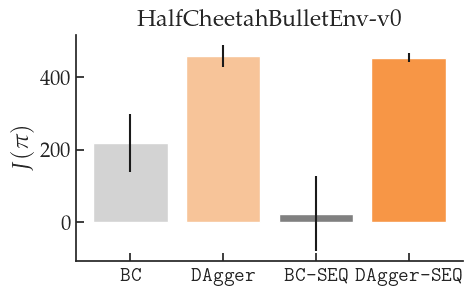

In [91]:
setup_plot()
algs = ['$\\texttt{BC}$', '$\\texttt{DAgger}$', '$\\texttt{BC-SEQ}$', '$\\texttt{DAgger-SEQ}$',]
perfs = [1000 + np.mean(bc_rewards), 1000 + np.mean(dagger_rewards), 1000 + np.mean(bc_seq_rewards), 1000 + np.mean(dagger_seq_rewards)]
ses = [np.std(bc_rewards) / np.sqrt(len(bc_rewards)),
       np.std(dagger_rewards) / np.sqrt(len(dagger_rewards)),
       np.std(bc_seq_rewards) / np.sqrt(len(bc_seq_rewards)),
       np.std(dagger_seq_rewards) / np.sqrt(len(dagger_seq_rewards))]
colors = ["lightgrey", "#f7c499", "grey", "#F79646"]
plt.bar(algs,perfs, yerr=ses, color=colors)
plt.ylabel("$J(\\pi)$")
plt.title("HalfCheetahBulletEnv-v0")
plt.savefig("hc_js.pdf", bbox_inches='tight')
plt.show()

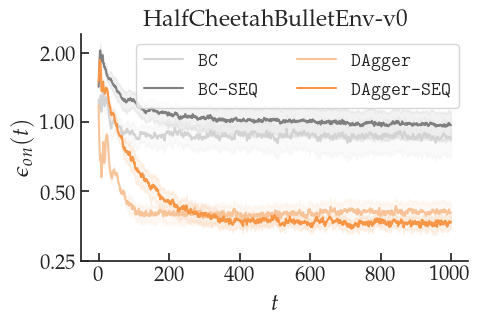

In [135]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

setup_plot()
plt.xlabel("$t$")
plt.ylabel("$\\epsilon_{on}(t)$")
plt.title("HalfCheetahBulletEnv-v0")

plt.plot(np.arange(len(bc_eps[0])), np.mean(bc_eps, axis=0), label="$\\texttt{BC}$", color="lightgrey")
plt.fill_between(np.arange(len(bc_eps[0])),
                 np.mean(bc_eps, axis=0) - (np.std(bc_eps, axis=0) / np.sqrt(len(bc_eps))),
                 np.mean(bc_eps, axis=0) + (np.std(bc_eps, axis=0) / np.sqrt(len(bc_eps))),
                 color = "lightgrey",
                 alpha = 0.1,)

plt.plot(np.arange(len(bc_seq_eps[0])), np.mean(bc_seq_eps, axis=0), label="$\\texttt{BC-SEQ}$", color="grey")
plt.fill_between(np.arange(len(bc_seq_eps[0])),
                 np.mean(bc_seq_eps, axis=0) - (np.std(bc_seq_eps, axis=0) / np.sqrt(len(bc_seq_eps))),
                 np.mean(bc_seq_eps, axis=0) + (np.std(bc_seq_eps, axis=0) / np.sqrt(len(bc_seq_eps))),
                 color = "grey",
                 alpha = 0.1)

plt.plot(np.arange(len(dagger_eps[0])), np.mean(dagger_eps, axis=0), label="$\\texttt{DAgger}$", color="#f7c499")
plt.fill_between(np.arange(len(dagger_eps[0])),
                 np.mean(dagger_eps, axis=0) - (np.std(dagger_eps, axis=0) / np.sqrt(len(dagger_eps))),
                 np.mean(dagger_eps, axis=0) + (np.std(dagger_eps, axis=0) / np.sqrt(len(dagger_eps))),
                 color = "#f7c499",
                 alpha = 0.1)

plt.plot(np.arange(len(dagger_seq_eps[0])), np.mean(dagger_seq_eps, axis=0), label="$\\texttt{DAgger-SEQ}$", color="#F79646")
plt.fill_between(np.arange(len(dagger_seq_eps[0])),
                 np.mean(dagger_seq_eps, axis=0) - (np.std(dagger_seq_eps, axis=0) / np.sqrt(len(dagger_seq_eps))),
                 np.mean(dagger_seq_eps, axis=0) + (np.std(dagger_seq_eps, axis=0) / np.sqrt(len(dagger_seq_eps))),
                 color = "#F79646",
                 alpha = 0.1)
plt.gca().set_yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter())
plt.minorticks_off()
plt.yticks([2, 1, 0.5, 0.25])
plt.legend(ncol=2, loc="upper right", fontsize=14)
plt.savefig("hc_eps.pdf", bbox_inches='tight')

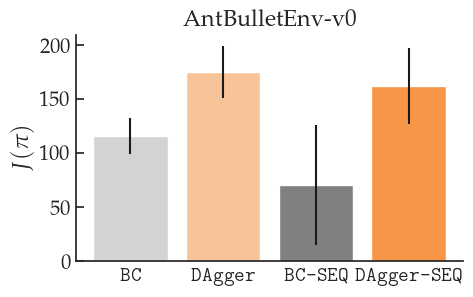

In [368]:
setup_plot()
algs = ['$\\texttt{BC}$', '$\\texttt{DAgger}$', '$\\texttt{BC-SEQ}$', '$\\texttt{DAgger-SEQ}$',]
perfs = [np.mean(bc_rewards2), np.mean(dagger_rewards2), np.mean(bc_seq_rewards2), np.mean(dagger_seq_rewards2)]
ses = [np.std(bc_rewards2) / np.sqrt(len(bc_rewards2)),
       np.std(dagger_rewards2) / np.sqrt(len(dagger_rewards2)),
       np.std(bc_seq_rewards2) / np.sqrt(len(bc_seq_rewards2)),
       np.std(dagger_seq_rewards2) / np.sqrt(len(dagger_seq_rewards2))]
colors = ["lightgrey", "#f7c499", "grey", "#F79646"]
plt.bar(algs,perfs, yerr=ses, color=colors)
plt.ylabel("$J(\\pi)$")
plt.title("AntBulletEnv-v0")
plt.savefig("ant_js.pdf", bbox_inches='tight')
plt.show()

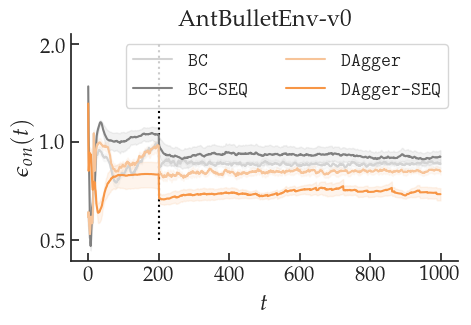

In [389]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

setup_plot()
plt.xlabel("$t$")
plt.ylabel("$\\epsilon_{on}(t)$")
plt.title("AntBulletEnv-v0")

plt.plot([200, 200], [0.5, 2], linestyle=":", color="black")
plt.plot(np.arange(len(bc_eps2[0])), np.mean(bc_eps2, axis=0), label="$\\texttt{BC}$", color="lightgrey")
plt.fill_between(np.arange(len(bc_eps2[0])),
                 np.mean(bc_eps2, axis=0) - (np.std(bc_eps2, axis=0) / np.sqrt(len(bc_eps2))),
                 np.mean(bc_eps2, axis=0) + (np.std(bc_eps2, axis=0) / np.sqrt(len(bc_eps2))),
                 color = "lightgrey",
                 alpha = 0.1,)

plt.plot(np.arange(len(bc_seq_eps2[0])), np.mean(bc_seq_eps2, axis=0), label="$\\texttt{BC-SEQ}$", color="grey")
plt.fill_between(np.arange(len(bc_seq_eps2[0])),
                 np.mean(bc_seq_eps2, axis=0) - (np.std(bc_seq_eps2, axis=0) / np.sqrt(len(bc_seq_eps2))),
                 np.mean(bc_seq_eps2, axis=0) + (np.std(bc_seq_eps2, axis=0) / np.sqrt(len(bc_seq_eps2))),
                 color = "grey",
                 alpha = 0.1)

plt.plot(np.arange(len(dagger_eps2[0])), np.mean(dagger_eps2, axis=0), label="$\\texttt{DAgger}$", color="#f7c499")
plt.fill_between(np.arange(len(dagger_eps2[0])),
                 np.mean(dagger_eps2, axis=0) - (np.std(dagger_eps2, axis=0) / np.sqrt(len(dagger_eps2))),
                 np.mean(dagger_eps2, axis=0) + (np.std(dagger_eps2, axis=0) / np.sqrt(len(dagger_eps2))),
                 color = "#f7c499",
                 alpha = 0.1)

plt.plot(np.arange(len(dagger_seq_eps2[0])), np.mean(dagger_seq_eps2, axis=0), label="$\\texttt{DAgger-SEQ}$", color="#F79646")
plt.fill_between(np.arange(len(dagger_seq_eps2[0])),
                 np.mean(dagger_seq_eps2, axis=0) - (np.std(dagger_seq_eps2, axis=0) / np.sqrt(len(dagger_seq_eps2))),
                 np.mean(dagger_seq_eps2, axis=0) + (np.std(dagger_seq_eps2, axis=0) / np.sqrt(len(dagger_seq_eps2))),
                 color = "#F79646",
                 alpha = 0.1)
plt.gca().set_yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter())
plt.minorticks_off()
plt.yticks([2, 1, 0.5])
plt.legend(ncol=2, loc="upper right", fontsize=14)
plt.savefig("ant_eps.pdf", bbox_inches='tight')